In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# from IPython.display import display
# pd.set_option('display.max_rows', 10)

In [2]:
# pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [3]:
# ### https://saturncloud.io/blog/how-to-change-the-path-in-google-colab/
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Colab Notebooks/dataset')
# pwd = '/content/drive/My Drive/Colab Notebooks/dataset'

In [4]:
## for weather data
# def data_preparation(data_name):
#     df = pd.read_csv(data_name)
#     sample_size = 50000
#     if data_name == 'shifts_canonical_train.csv':
#         df = df.sample( n = 80000, random_state = 1 , ignore_index = True)
#     else:
#         df = df.sample( n = sample_size, random_state = 1 , ignore_index = True)

#     df = df.dropna()

#     y = df['fact_temperature'].to_numpy()
#     y = y.reshape(-1,1)
#     df = df.iloc[:,6:]
#     X = df.to_numpy()
#     return X, y


In [5]:
def data_preparation(data):
    df = pd.read_csv(data)
    if data == "train.csv":
      df = df.sample(n= 60000, random_state=1)
    y = df.pop('power')
    y = y.to_numpy()
    y = y.reshape(-1,1)
    X = df.to_numpy()
    return X, y

In [6]:
seed = 23
X, y = data_preparation('train.csv')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= seed)

scaler1 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train)
X_val = scaler1.transform(X_val)
X_test = scaler1.transform(X_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_val = scaler2.transform(y_val)
y_test = scaler2.transform(y_test)
X_train.shape

(43200, 11)

In [8]:
X_small_shift, y_small_shift = data_preparation('dev_in.csv')
X_large_shift, y_large_shift = data_preparation('dev_out.csv')

In [9]:
def normalization(X, y):
  scaler_1 = MinMaxScaler()
  scaler_2 = MinMaxScaler()
  X = scaler1.fit_transform(X)
  y = scaler2.fit_transform(y)
  return X, y

X_small_shift, y_small_shift = normalization(X_small_shift, y_small_shift)
X_large_shift, y_large_shift = normalization(X_large_shift, y_large_shift)

In [10]:
# OOD data 1
OOD_1 = pd.read_csv('Boston.csv')
OOD_1 = OOD_1.to_numpy()


In [11]:
# OOD data 2
OOD_2 = pd.read_csv('naval.csv')
OOD_2 = OOD_2.to_numpy()
OOD_2.shape

(11934, 11)

In [12]:
# df_describe = pd.DataFrame(X_train)
# df_describe.describe()

In [13]:
import matplotlib.pyplot as plt
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
tf.autograph.set_verbosity(0)
import official.nlp.modeling.layers as nlp_layers

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [14]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [15]:
resnet_config = dict(num_classes = 1, num_layers= 3, num_hidden= 512)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build( (None, 11) )
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6144      
                                                                 
 dense_1 (Dense)             multiple                  262656    
                                                                 
 dense_2 (Dense)             multiple                  262656    
                                                                 
 dense_3 (Dense)             multiple                  262656    
                                                                 
 dense_4 (Dense)             multiple                  513       
                                                                 
Total params: 794,625
Trainable params: 788,481
Non-trainable params: 6,144
_________________________________________________________________


In [16]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

fit_config = dict(batch_size= 512,  epochs= 1000,
                validation_data = (X_val, y_val),
                callbacks=[callback] )

In [17]:
resnet_model.compile(**train_config)
history = resnet_model.fit( x = X_train, y = y_train,
                           **fit_config )

Epoch 1/1000
85/85 [==============================] - 2s 5ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 4/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 5/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 6/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 7/1000
85/85 [========

Epoch 51/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.1711e-04 - val_mean_squared_error: 9.1711e-04
Epoch 52/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.5220e-04 - val_mean_squared_error: 8.5220e-04
Epoch 53/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.9004e-04 - val_mean_squared_error: 8.9004e-04
Epoch 54/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.6747e-04 - val_mean_squared_error: 8.6747e-04
Epoch 55/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.6518e-04 - val_mean_squared_error: 8.6518e-04
Epoch 56/1000
85/85 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.9184e-04 - val_mean_

85/85 [==============================] - 0s 3ms/step - loss: 8.3481e-04 - mean_squared_error: 8.3481e-04 - val_loss: 8.4416e-04 - val_mean_squared_error: 8.4416e-04
Epoch 98/1000
85/85 [==============================] - 0s 3ms/step - loss: 8.0807e-04 - mean_squared_error: 8.0807e-04 - val_loss: 7.3655e-04 - val_mean_squared_error: 7.3655e-04
Epoch 99/1000
85/85 [==============================] - 0s 3ms/step - loss: 8.2095e-04 - mean_squared_error: 8.2095e-04 - val_loss: 8.4718e-04 - val_mean_squared_error: 8.4718e-04
Epoch 100/1000
85/85 [==============================] - 0s 3ms/step - loss: 8.2131e-04 - mean_squared_error: 8.2131e-04 - val_loss: 7.2840e-04 - val_mean_squared_error: 7.2840e-04
Epoch 101/1000
85/85 [==============================] - 0s 3ms/step - loss: 8.0947e-04 - mean_squared_error: 8.0947e-04 - val_loss: 7.4855e-04 - val_mean_squared_error: 7.4855e-04
Epoch 102/1000
85/85 [==============================] - 0s 3ms/step - loss: 8.1951e-04 - mean_squared_error: 8.1951e-

Epoch 143/1000
85/85 [==============================] - 0s 3ms/step - loss: 7.1864e-04 - mean_squared_error: 7.1864e-04 - val_loss: 6.9628e-04 - val_mean_squared_error: 6.9628e-04
Epoch 144/1000
85/85 [==============================] - 0s 3ms/step - loss: 7.2040e-04 - mean_squared_error: 7.2040e-04 - val_loss: 6.6756e-04 - val_mean_squared_error: 6.6756e-04
Epoch 145/1000
85/85 [==============================] - 0s 3ms/step - loss: 7.1452e-04 - mean_squared_error: 7.1452e-04 - val_loss: 6.7212e-04 - val_mean_squared_error: 6.7212e-04
Epoch 146/1000
85/85 [==============================] - 0s 3ms/step - loss: 7.1846e-04 - mean_squared_error: 7.1846e-04 - val_loss: 6.8867e-04 - val_mean_squared_error: 6.8867e-04
Epoch 147/1000
85/85 [==============================] - 0s 3ms/step - loss: 7.1951e-04 - mean_squared_error: 7.1951e-04 - val_loss: 6.6820e-04 - val_mean_squared_error: 6.6820e-04
Epoch 148/1000
85/85 [==============================] - 0s 3ms/step - loss: 7.0922e-04 - mean_square

85/85 [==============================] - 0s 3ms/step - loss: 6.4911e-04 - mean_squared_error: 6.4911e-04 - val_loss: 6.1397e-04 - val_mean_squared_error: 6.1397e-04
Epoch 189/1000
85/85 [==============================] - 0s 3ms/step - loss: 6.4773e-04 - mean_squared_error: 6.4773e-04 - val_loss: 6.5040e-04 - val_mean_squared_error: 6.5040e-04
Epoch 190/1000
85/85 [==============================] - 0s 3ms/step - loss: 6.5054e-04 - mean_squared_error: 6.5054e-04 - val_loss: 6.2984e-04 - val_mean_squared_error: 6.2984e-04
Epoch 191/1000
85/85 [==============================] - 0s 3ms/step - loss: 6.5245e-04 - mean_squared_error: 6.5245e-04 - val_loss: 6.4927e-04 - val_mean_squared_error: 6.4927e-04
Epoch 192/1000
85/85 [==============================] - 0s 3ms/step - loss: 6.4676e-04 - mean_squared_error: 6.4676e-04 - val_loss: 6.6623e-04 - val_mean_squared_error: 6.6623e-04
Epoch 193/1000
85/85 [==============================] - 0s 3ms/step - loss: 6.4362e-04 - mean_squared_error: 6.4362

85/85 [==============================] - 0s 3ms/step - loss: 5.9817e-04 - mean_squared_error: 5.9817e-04 - val_loss: 5.9855e-04 - val_mean_squared_error: 5.9855e-04
Epoch 234/1000
85/85 [==============================] - 0s 3ms/step - loss: 6.0855e-04 - mean_squared_error: 6.0855e-04 - val_loss: 5.9599e-04 - val_mean_squared_error: 5.9599e-04
Epoch 235/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.8564e-04 - mean_squared_error: 5.8564e-04 - val_loss: 5.9101e-04 - val_mean_squared_error: 5.9101e-04
Epoch 236/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.9032e-04 - mean_squared_error: 5.9032e-04 - val_loss: 6.4201e-04 - val_mean_squared_error: 6.4201e-04
Epoch 237/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.9817e-04 - mean_squared_error: 5.9817e-04 - val_loss: 5.7485e-04 - val_mean_squared_error: 5.7485e-04
Epoch 238/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.9554e-04 - mean_squared_error: 5.9554

85/85 [==============================] - 0s 3ms/step - loss: 5.6302e-04 - mean_squared_error: 5.6302e-04 - val_loss: 5.5988e-04 - val_mean_squared_error: 5.5988e-04
Epoch 279/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.5108e-04 - mean_squared_error: 5.5108e-04 - val_loss: 6.1149e-04 - val_mean_squared_error: 6.1149e-04
Epoch 280/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.5152e-04 - mean_squared_error: 5.5152e-04 - val_loss: 5.5832e-04 - val_mean_squared_error: 5.5832e-04
Epoch 281/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.5490e-04 - mean_squared_error: 5.5490e-04 - val_loss: 5.9016e-04 - val_mean_squared_error: 5.9016e-04
Epoch 282/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.5553e-04 - mean_squared_error: 5.5553e-04 - val_loss: 5.7421e-04 - val_mean_squared_error: 5.7421e-04
Epoch 283/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.6989e-04 - mean_squared_error: 5.6989

85/85 [==============================] - 0s 3ms/step - loss: 5.2115e-04 - mean_squared_error: 5.2115e-04 - val_loss: 5.3974e-04 - val_mean_squared_error: 5.3974e-04
Epoch 324/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.2360e-04 - mean_squared_error: 5.2360e-04 - val_loss: 5.2778e-04 - val_mean_squared_error: 5.2778e-04
Epoch 325/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.2022e-04 - mean_squared_error: 5.2022e-04 - val_loss: 5.8771e-04 - val_mean_squared_error: 5.8771e-04
Epoch 326/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.1766e-04 - mean_squared_error: 5.1766e-04 - val_loss: 6.2109e-04 - val_mean_squared_error: 6.2109e-04
Epoch 327/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.2638e-04 - mean_squared_error: 5.2638e-04 - val_loss: 5.3996e-04 - val_mean_squared_error: 5.3996e-04
Epoch 328/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.1269e-04 - mean_squared_error: 5.1269

85/85 [==============================] - 0s 3ms/step - loss: 4.8975e-04 - mean_squared_error: 4.8975e-04 - val_loss: 5.0959e-04 - val_mean_squared_error: 5.0959e-04
Epoch 369/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.8547e-04 - mean_squared_error: 4.8547e-04 - val_loss: 5.2344e-04 - val_mean_squared_error: 5.2344e-04
Epoch 370/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.8799e-04 - mean_squared_error: 4.8799e-04 - val_loss: 5.2978e-04 - val_mean_squared_error: 5.2978e-04
Epoch 371/1000
85/85 [==============================] - 0s 3ms/step - loss: 5.0075e-04 - mean_squared_error: 5.0075e-04 - val_loss: 5.2782e-04 - val_mean_squared_error: 5.2782e-04
Epoch 372/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.8895e-04 - mean_squared_error: 4.8895e-04 - val_loss: 6.1631e-04 - val_mean_squared_error: 6.1631e-04
Epoch 373/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.9097e-04 - mean_squared_error: 4.9097

85/85 [==============================] - 0s 3ms/step - loss: 4.6227e-04 - mean_squared_error: 4.6227e-04 - val_loss: 5.0207e-04 - val_mean_squared_error: 5.0207e-04
Epoch 414/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.6847e-04 - mean_squared_error: 4.6847e-04 - val_loss: 5.1927e-04 - val_mean_squared_error: 5.1927e-04
Epoch 415/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.6226e-04 - mean_squared_error: 4.6226e-04 - val_loss: 5.1360e-04 - val_mean_squared_error: 5.1360e-04
Epoch 416/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.6035e-04 - mean_squared_error: 4.6035e-04 - val_loss: 5.1060e-04 - val_mean_squared_error: 5.1060e-04
Epoch 417/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.6155e-04 - mean_squared_error: 4.6155e-04 - val_loss: 5.0764e-04 - val_mean_squared_error: 5.0764e-04
Epoch 418/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.6772e-04 - mean_squared_error: 4.6772

85/85 [==============================] - 0s 3ms/step - loss: 4.5653e-04 - mean_squared_error: 4.5653e-04 - val_loss: 6.2047e-04 - val_mean_squared_error: 6.2047e-04
Epoch 459/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.3119e-04 - mean_squared_error: 4.3119e-04 - val_loss: 4.8666e-04 - val_mean_squared_error: 4.8666e-04
Epoch 460/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.4151e-04 - mean_squared_error: 4.4151e-04 - val_loss: 4.8207e-04 - val_mean_squared_error: 4.8207e-04
Epoch 461/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.3369e-04 - mean_squared_error: 4.3369e-04 - val_loss: 4.7683e-04 - val_mean_squared_error: 4.7683e-04
Epoch 462/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.5218e-04 - mean_squared_error: 4.5218e-04 - val_loss: 4.9033e-04 - val_mean_squared_error: 4.9033e-04
Epoch 463/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.3463e-04 - mean_squared_error: 4.3463

85/85 [==============================] - 0s 3ms/step - loss: 4.2093e-04 - mean_squared_error: 4.2093e-04 - val_loss: 4.9154e-04 - val_mean_squared_error: 4.9154e-04
Epoch 504/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.1950e-04 - mean_squared_error: 4.1950e-04 - val_loss: 5.5158e-04 - val_mean_squared_error: 5.5158e-04
Epoch 505/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.1884e-04 - mean_squared_error: 4.1884e-04 - val_loss: 4.9785e-04 - val_mean_squared_error: 4.9785e-04
Epoch 506/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.1718e-04 - mean_squared_error: 4.1718e-04 - val_loss: 4.8533e-04 - val_mean_squared_error: 4.8533e-04
Epoch 507/1000
85/85 [==============================] - 0s 4ms/step - loss: 4.1911e-04 - mean_squared_error: 4.1911e-04 - val_loss: 5.0676e-04 - val_mean_squared_error: 5.0676e-04
Epoch 508/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.2134e-04 - mean_squared_error: 4.2134

85/85 [==============================] - 0s 4ms/step - loss: 3.9731e-04 - mean_squared_error: 3.9731e-04 - val_loss: 4.9031e-04 - val_mean_squared_error: 4.9031e-04
Epoch 549/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.9913e-04 - mean_squared_error: 3.9913e-04 - val_loss: 4.5390e-04 - val_mean_squared_error: 4.5390e-04
Epoch 550/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.9894e-04 - mean_squared_error: 3.9894e-04 - val_loss: 4.4927e-04 - val_mean_squared_error: 4.4927e-04
Epoch 551/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.0112e-04 - mean_squared_error: 4.0112e-04 - val_loss: 5.3798e-04 - val_mean_squared_error: 5.3798e-04
Epoch 552/1000
85/85 [==============================] - 0s 3ms/step - loss: 4.0935e-04 - mean_squared_error: 4.0935e-04 - val_loss: 4.5737e-04 - val_mean_squared_error: 4.5737e-04
Epoch 553/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.9456e-04 - mean_squared_error: 3.9456

85/85 [==============================] - 0s 3ms/step - loss: 3.8707e-04 - mean_squared_error: 3.8707e-04 - val_loss: 4.5043e-04 - val_mean_squared_error: 4.5043e-04
Epoch 594/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.7787e-04 - mean_squared_error: 3.7787e-04 - val_loss: 4.8103e-04 - val_mean_squared_error: 4.8103e-04
Epoch 595/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.7765e-04 - mean_squared_error: 3.7765e-04 - val_loss: 5.2344e-04 - val_mean_squared_error: 5.2344e-04
Epoch 596/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.8996e-04 - mean_squared_error: 3.8996e-04 - val_loss: 4.5798e-04 - val_mean_squared_error: 4.5798e-04
Epoch 597/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.7880e-04 - mean_squared_error: 3.7880e-04 - val_loss: 4.6151e-04 - val_mean_squared_error: 4.6151e-04
Epoch 598/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.8068e-04 - mean_squared_error: 3.8068

85/85 [==============================] - 0s 3ms/step - loss: 3.6510e-04 - mean_squared_error: 3.6510e-04 - val_loss: 4.5148e-04 - val_mean_squared_error: 4.5148e-04
Epoch 639/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.6313e-04 - mean_squared_error: 3.6313e-04 - val_loss: 4.7324e-04 - val_mean_squared_error: 4.7324e-04
Epoch 640/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.6990e-04 - mean_squared_error: 3.6990e-04 - val_loss: 4.4035e-04 - val_mean_squared_error: 4.4035e-04
Epoch 641/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.6285e-04 - mean_squared_error: 3.6285e-04 - val_loss: 4.4368e-04 - val_mean_squared_error: 4.4368e-04
Epoch 642/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.6273e-04 - mean_squared_error: 3.6273e-04 - val_loss: 4.4543e-04 - val_mean_squared_error: 4.4543e-04
Epoch 643/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.6389e-04 - mean_squared_error: 3.6389

85/85 [==============================] - 0s 3ms/step - loss: 3.4705e-04 - mean_squared_error: 3.4705e-04 - val_loss: 4.3275e-04 - val_mean_squared_error: 4.3275e-04
Epoch 684/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.5664e-04 - mean_squared_error: 3.5664e-04 - val_loss: 4.2872e-04 - val_mean_squared_error: 4.2872e-04
Epoch 685/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.4713e-04 - mean_squared_error: 3.4713e-04 - val_loss: 4.3627e-04 - val_mean_squared_error: 4.3627e-04
Epoch 686/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.5811e-04 - mean_squared_error: 3.5811e-04 - val_loss: 4.5912e-04 - val_mean_squared_error: 4.5912e-04
Epoch 687/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.5799e-04 - mean_squared_error: 3.5799e-04 - val_loss: 4.7475e-04 - val_mean_squared_error: 4.7475e-04
Epoch 688/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.4529e-04 - mean_squared_error: 3.4529

85/85 [==============================] - 0s 3ms/step - loss: 3.4399e-04 - mean_squared_error: 3.4399e-04 - val_loss: 4.7782e-04 - val_mean_squared_error: 4.7782e-04
Epoch 729/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.4017e-04 - mean_squared_error: 3.4017e-04 - val_loss: 4.1723e-04 - val_mean_squared_error: 4.1723e-04
Epoch 730/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.3823e-04 - mean_squared_error: 3.3823e-04 - val_loss: 4.3470e-04 - val_mean_squared_error: 4.3470e-04
Epoch 731/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.3581e-04 - mean_squared_error: 3.3581e-04 - val_loss: 4.3775e-04 - val_mean_squared_error: 4.3775e-04
Epoch 732/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.4170e-04 - mean_squared_error: 3.4170e-04 - val_loss: 4.2194e-04 - val_mean_squared_error: 4.2194e-04
Epoch 733/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.3833e-04 - mean_squared_error: 3.3833

85/85 [==============================] - 0s 3ms/step - loss: 3.2315e-04 - mean_squared_error: 3.2315e-04 - val_loss: 4.6941e-04 - val_mean_squared_error: 4.6941e-04
Epoch 774/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.2931e-04 - mean_squared_error: 3.2931e-04 - val_loss: 4.2374e-04 - val_mean_squared_error: 4.2374e-04
Epoch 775/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.2953e-04 - mean_squared_error: 3.2953e-04 - val_loss: 4.2532e-04 - val_mean_squared_error: 4.2532e-04
Epoch 776/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.2091e-04 - mean_squared_error: 3.2091e-04 - val_loss: 4.1714e-04 - val_mean_squared_error: 4.1714e-04
Epoch 777/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.3267e-04 - mean_squared_error: 3.3267e-04 - val_loss: 4.6147e-04 - val_mean_squared_error: 4.6147e-04
Epoch 778/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.2508e-04 - mean_squared_error: 3.2508

85/85 [==============================] - 0s 4ms/step - loss: 3.1020e-04 - mean_squared_error: 3.1020e-04 - val_loss: 4.0783e-04 - val_mean_squared_error: 4.0783e-04
Epoch 819/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.1794e-04 - mean_squared_error: 3.1794e-04 - val_loss: 4.4630e-04 - val_mean_squared_error: 4.4630e-04
Epoch 820/1000
85/85 [==============================] - 0s 4ms/step - loss: 3.1820e-04 - mean_squared_error: 3.1820e-04 - val_loss: 4.3012e-04 - val_mean_squared_error: 4.3012e-04
Epoch 821/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.1735e-04 - mean_squared_error: 3.1735e-04 - val_loss: 4.0577e-04 - val_mean_squared_error: 4.0577e-04
Epoch 822/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.1492e-04 - mean_squared_error: 3.1492e-04 - val_loss: 4.0596e-04 - val_mean_squared_error: 4.0596e-04
Epoch 823/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.1679e-04 - mean_squared_error: 3.1679

85/85 [==============================] - 0s 3ms/step - loss: 3.0839e-04 - mean_squared_error: 3.0839e-04 - val_loss: 4.0596e-04 - val_mean_squared_error: 4.0596e-04
Epoch 864/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0667e-04 - mean_squared_error: 3.0667e-04 - val_loss: 4.2121e-04 - val_mean_squared_error: 4.2121e-04
Epoch 865/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0491e-04 - mean_squared_error: 3.0491e-04 - val_loss: 4.1440e-04 - val_mean_squared_error: 4.1440e-04
Epoch 866/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0982e-04 - mean_squared_error: 3.0982e-04 - val_loss: 4.3987e-04 - val_mean_squared_error: 4.3987e-04
Epoch 867/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0235e-04 - mean_squared_error: 3.0235e-04 - val_loss: 4.0362e-04 - val_mean_squared_error: 4.0362e-04
Epoch 868/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0587e-04 - mean_squared_error: 3.0587

85/85 [==============================] - 0s 3ms/step - loss: 3.0265e-04 - mean_squared_error: 3.0265e-04 - val_loss: 4.0761e-04 - val_mean_squared_error: 4.0761e-04
Epoch 909/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.9493e-04 - mean_squared_error: 2.9493e-04 - val_loss: 4.0809e-04 - val_mean_squared_error: 4.0809e-04
Epoch 910/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0049e-04 - mean_squared_error: 3.0049e-04 - val_loss: 4.0834e-04 - val_mean_squared_error: 4.0834e-04
Epoch 911/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0613e-04 - mean_squared_error: 3.0613e-04 - val_loss: 4.0222e-04 - val_mean_squared_error: 4.0222e-04
Epoch 912/1000
85/85 [==============================] - 0s 3ms/step - loss: 3.0746e-04 - mean_squared_error: 3.0746e-04 - val_loss: 4.0372e-04 - val_mean_squared_error: 4.0372e-04
Epoch 913/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.9754e-04 - mean_squared_error: 2.9754

85/85 [==============================] - 0s 3ms/step - loss: 2.8902e-04 - mean_squared_error: 2.8902e-04 - val_loss: 4.2514e-04 - val_mean_squared_error: 4.2514e-04
Epoch 954/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.9047e-04 - mean_squared_error: 2.9047e-04 - val_loss: 4.0000e-04 - val_mean_squared_error: 4.0000e-04
Epoch 955/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.8813e-04 - mean_squared_error: 2.8813e-04 - val_loss: 4.4458e-04 - val_mean_squared_error: 4.4458e-04
Epoch 956/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.8949e-04 - mean_squared_error: 2.8949e-04 - val_loss: 4.0772e-04 - val_mean_squared_error: 4.0772e-04
Epoch 957/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.9448e-04 - mean_squared_error: 2.9448e-04 - val_loss: 3.9056e-04 - val_mean_squared_error: 3.9056e-04
Epoch 958/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.8581e-04 - mean_squared_error: 2.8581

85/85 [==============================] - 0s 3ms/step - loss: 2.8469e-04 - mean_squared_error: 2.8469e-04 - val_loss: 3.9512e-04 - val_mean_squared_error: 3.9512e-04
Epoch 999/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.8579e-04 - mean_squared_error: 2.8579e-04 - val_loss: 3.9038e-04 - val_mean_squared_error: 3.9038e-04
Epoch 1000/1000
85/85 [==============================] - 0s 3ms/step - loss: 2.8176e-04 - mean_squared_error: 2.8176e-04 - val_loss: 4.0489e-04 - val_mean_squared_error: 4.0489e-04


<AxesSubplot:>

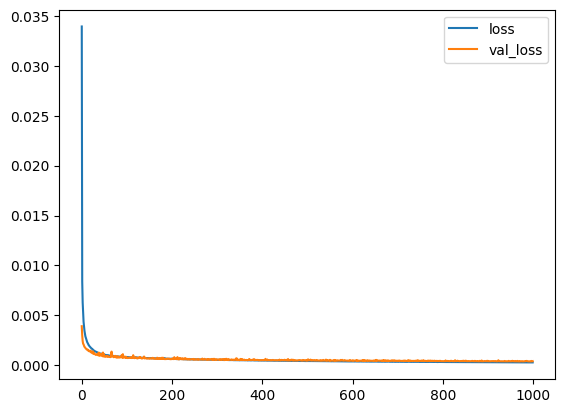

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

# print(("Best Validation Loss: {:0.4f}" +\
#       "\nBest Validation Accuracy: {:0.4f}")\
#       .format(history_df['val_loss'].min(),
#               history_df['val_sparse_categorical_accuracy'].max()))

In [19]:
resnet_model.evaluate(X_test, y_test)

375/375 [==============================] - 1s 2ms/step - loss: 4.1173e-04 - mean_squared_error: 4.1173e-04


[0.00041172702913172543, 0.00041172702913172543]

In [20]:
resnet_model.evaluate(X_small_shift, y_small_shift)

574/574 [==============================] - 1s 2ms/step - loss: 5.0381e-04 - mean_squared_error: 5.0381e-04


[0.0005038067465648055, 0.0005038067465648055]

In [21]:
resnet_model.evaluate(X_large_shift, y_large_shift)

574/574 [==============================] - 1s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043


[0.004345858469605446, 0.004345858469605446]

In [22]:
#resnet_model.evaluate( scaler1.inverse_transform(X_test), scaler2.inverse_transform(y_test) )

In [23]:
import official.nlp.modeling.layers as nlp_layers

In [24]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [25]:
# Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [26]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [27]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [28]:
# Train model
fit_config = dict(batch_size= 512,  epochs= 4000,
                validation_data = (X_val, y_val),
                callbacks=[callback] )

In [29]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

Epoch 1/4000
85/85 [==============================] - 2s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0098 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 3/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 4/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 7/4000
85/85 [========

85/85 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 52/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 53/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 9.9747e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 54/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 55/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 56/4000
85/85 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 57/4000
85/85 [===========

85/85 [==============================] - 1s 6ms/step - loss: 9.2208e-04 - mean_squared_error: 9.1786e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 100/4000
85/85 [==============================] - 1s 6ms/step - loss: 9.2086e-04 - mean_squared_error: 9.1663e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 101/4000
85/85 [==============================] - 0s 6ms/step - loss: 9.4721e-04 - mean_squared_error: 9.4297e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 102/4000
85/85 [==============================] - 1s 6ms/step - loss: 9.3656e-04 - mean_squared_error: 9.3231e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 103/4000
85/85 [==============================] - 0s 5ms/step - loss: 9.3063e-04 - mean_squared_error: 9.2638e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 104/4000
85/85 [==============================] - 0s 6ms/step - loss: 9.2701e-04 - mean_squared_error: 9.2275e-04 - val_loss: 0.0013 - val_mean_squar

Epoch 147/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.7099e-04 - mean_squared_error: 8.6640e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 148/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.9005e-04 - mean_squared_error: 8.8545e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 149/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.6886e-04 - mean_squared_error: 8.6425e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 150/4000
85/85 [==============================] - 0s 5ms/step - loss: 8.9491e-04 - mean_squared_error: 8.9030e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 151/4000
85/85 [==============================] - 0s 5ms/step - loss: 8.7016e-04 - mean_squared_error: 8.6554e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0014
Epoch 152/4000
85/85 [==============================] - 0s 5ms/step - loss: 8.7498e-04 - mean_squared_error: 8.7036e-04 - val_loss: 0.0016 -

85/85 [==============================] - 0s 5ms/step - loss: 8.4610e-04 - mean_squared_error: 8.4120e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 195/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.3743e-04 - mean_squared_error: 8.3253e-04 - val_loss: 9.6489e-04 - val_mean_squared_error: 9.5999e-04
Epoch 196/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.4899e-04 - mean_squared_error: 8.4408e-04 - val_loss: 9.3536e-04 - val_mean_squared_error: 9.3045e-04
Epoch 197/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.3603e-04 - mean_squared_error: 8.3111e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 198/4000
85/85 [==============================] - 0s 5ms/step - loss: 8.3858e-04 - mean_squared_error: 8.3366e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 199/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.3487e-04 - mean_squared_error: 8.2995e-04 - val_loss: 0.0011 

85/85 [==============================] - 0s 6ms/step - loss: 8.1485e-04 - mean_squared_error: 8.0970e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 242/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.2037e-04 - mean_squared_error: 8.1521e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 243/4000
85/85 [==============================] - 1s 6ms/step - loss: 8.0617e-04 - mean_squared_error: 8.0101e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 244/4000
85/85 [==============================] - 1s 6ms/step - loss: 8.2062e-04 - mean_squared_error: 8.1545e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 245/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.2333e-04 - mean_squared_error: 8.1816e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 246/4000
85/85 [==============================] - 0s 6ms/step - loss: 8.2130e-04 - mean_squared_error: 8.1613e-04 - val_loss: 9.7101e-04 - val_mean_s

85/85 [==============================] - 0s 6ms/step - loss: 8.0980e-04 - mean_squared_error: 8.0444e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 289/4000
85/85 [==============================] - 0s 5ms/step - loss: 8.0038e-04 - mean_squared_error: 7.9502e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 290/4000
85/85 [==============================] - 0s 5ms/step - loss: 8.1245e-04 - mean_squared_error: 8.0708e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 291/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.9696e-04 - mean_squared_error: 7.9158e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 292/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.9853e-04 - mean_squared_error: 7.9315e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 293/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.9239e-04 - mean_squared_error: 7.8701e-04 - val_loss: 9.7285e-04 - val_mean_s

85/85 [==============================] - 1s 6ms/step - loss: 7.9108e-04 - mean_squared_error: 7.8552e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 336/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.8849e-04 - mean_squared_error: 7.8293e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 337/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.8298e-04 - mean_squared_error: 7.7742e-04 - val_loss: 9.6921e-04 - val_mean_squared_error: 9.6365e-04
Epoch 338/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.7574e-04 - mean_squared_error: 7.7017e-04 - val_loss: 8.6223e-04 - val_mean_squared_error: 8.5666e-04
Epoch 339/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.9101e-04 - mean_squared_error: 7.8543e-04 - val_loss: 8.7301e-04 - val_mean_squared_error: 8.6743e-04
Epoch 340/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.8328e-04 - mean_squared_error: 7.7770e-04 - val_loss:

85/85 [==============================] - 0s 6ms/step - loss: 7.6723e-04 - mean_squared_error: 7.6149e-04 - val_loss: 8.6045e-04 - val_mean_squared_error: 8.5471e-04
Epoch 382/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.6678e-04 - mean_squared_error: 7.6104e-04 - val_loss: 9.9863e-04 - val_mean_squared_error: 9.9288e-04
Epoch 383/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.7868e-04 - mean_squared_error: 7.7294e-04 - val_loss: 8.2663e-04 - val_mean_squared_error: 8.2088e-04
Epoch 384/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.7598e-04 - mean_squared_error: 7.7023e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 385/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.7651e-04 - mean_squared_error: 7.7076e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 386/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.8576e-04 - mean_squared_error: 7.8000e-04 - val_loss:

85/85 [==============================] - 1s 7ms/step - loss: 7.6850e-04 - mean_squared_error: 7.6257e-04 - val_loss: 8.4635e-04 - val_mean_squared_error: 8.4042e-04
Epoch 428/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.7040e-04 - mean_squared_error: 7.6447e-04 - val_loss: 8.8118e-04 - val_mean_squared_error: 8.7524e-04
Epoch 429/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.5867e-04 - mean_squared_error: 7.5273e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 430/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.5981e-04 - mean_squared_error: 7.5387e-04 - val_loss: 9.8961e-04 - val_mean_squared_error: 9.8366e-04
Epoch 431/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.6725e-04 - mean_squared_error: 7.6130e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 432/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.6524e-04 - mean_squared_error: 7.5929e-04 - val_loss:

85/85 [==============================] - 1s 6ms/step - loss: 7.5678e-04 - mean_squared_error: 7.5067e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 474/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.4883e-04 - mean_squared_error: 7.4272e-04 - val_loss: 8.6638e-04 - val_mean_squared_error: 8.6026e-04
Epoch 475/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.5212e-04 - mean_squared_error: 7.4601e-04 - val_loss: 9.5974e-04 - val_mean_squared_error: 9.5363e-04
Epoch 476/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.4723e-04 - mean_squared_error: 7.4111e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 477/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.6402e-04 - mean_squared_error: 7.5790e-04 - val_loss: 9.6806e-04 - val_mean_squared_error: 9.6193e-04
Epoch 478/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.5660e-04 - mean_squared_error: 7.5047e-04 - val_loss:

85/85 [==============================] - 0s 5ms/step - loss: 7.5789e-04 - mean_squared_error: 7.5160e-04 - val_loss: 8.5189e-04 - val_mean_squared_error: 8.4560e-04
Epoch 520/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.4575e-04 - mean_squared_error: 7.3945e-04 - val_loss: 8.0599e-04 - val_mean_squared_error: 7.9969e-04
Epoch 521/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.4961e-04 - mean_squared_error: 7.4331e-04 - val_loss: 7.7027e-04 - val_mean_squared_error: 7.6398e-04
Epoch 522/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.4740e-04 - mean_squared_error: 7.4110e-04 - val_loss: 8.9049e-04 - val_mean_squared_error: 8.8419e-04
Epoch 523/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.3966e-04 - mean_squared_error: 7.3335e-04 - val_loss: 9.0870e-04 - val_mean_squared_error: 9.0239e-04
Epoch 524/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.4721e-04 - mean_squared_error: 7.4090

Epoch 565/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.3552e-04 - mean_squared_error: 7.2907e-04 - val_loss: 8.4485e-04 - val_mean_squared_error: 8.3839e-04
Epoch 566/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.3661e-04 - mean_squared_error: 7.3016e-04 - val_loss: 8.3337e-04 - val_mean_squared_error: 8.2692e-04
Epoch 567/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.4298e-04 - mean_squared_error: 7.3653e-04 - val_loss: 8.3248e-04 - val_mean_squared_error: 8.2602e-04
Epoch 568/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.3507e-04 - mean_squared_error: 7.2861e-04 - val_loss: 9.8138e-04 - val_mean_squared_error: 9.7492e-04
Epoch 569/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.4284e-04 - mean_squared_error: 7.3638e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 570/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.3979e-04 - mean_squared_error:

Epoch 611/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.3500e-04 - mean_squared_error: 7.2839e-04 - val_loss: 8.8334e-04 - val_mean_squared_error: 8.7672e-04
Epoch 612/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.2902e-04 - mean_squared_error: 7.2240e-04 - val_loss: 9.2783e-04 - val_mean_squared_error: 9.2122e-04
Epoch 613/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.4668e-04 - mean_squared_error: 7.4006e-04 - val_loss: 9.5726e-04 - val_mean_squared_error: 9.5064e-04
Epoch 614/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.2795e-04 - mean_squared_error: 7.2133e-04 - val_loss: 9.3701e-04 - val_mean_squared_error: 9.3039e-04
Epoch 615/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.1707e-04 - mean_squared_error: 7.1044e-04 - val_loss: 9.8547e-04 - val_mean_squared_error: 9.7885e-04
Epoch 616/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.3201e-04 - mean_square

85/85 [==============================] - 0s 6ms/step - loss: 7.2278e-04 - mean_squared_error: 7.1602e-04 - val_loss: 8.5535e-04 - val_mean_squared_error: 8.4859e-04
Epoch 657/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.3653e-04 - mean_squared_error: 7.2976e-04 - val_loss: 8.3675e-04 - val_mean_squared_error: 8.2998e-04
Epoch 658/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.3648e-04 - mean_squared_error: 7.2972e-04 - val_loss: 8.0598e-04 - val_mean_squared_error: 7.9921e-04
Epoch 659/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.2319e-04 - mean_squared_error: 7.1642e-04 - val_loss: 9.4338e-04 - val_mean_squared_error: 9.3661e-04
Epoch 660/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.2176e-04 - mean_squared_error: 7.1499e-04 - val_loss: 9.3445e-04 - val_mean_squared_error: 9.2768e-04
Epoch 661/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.2529e-04 - mean_squared_error: 7.1851

Epoch 702/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.1932e-04 - mean_squared_error: 7.1241e-04 - val_loss: 8.5124e-04 - val_mean_squared_error: 8.4434e-04
Epoch 703/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.2598e-04 - mean_squared_error: 7.1907e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 704/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.1817e-04 - mean_squared_error: 7.1126e-04 - val_loss: 8.0565e-04 - val_mean_squared_error: 7.9873e-04
Epoch 705/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.1661e-04 - mean_squared_error: 7.0969e-04 - val_loss: 8.1501e-04 - val_mean_squared_error: 8.0809e-04
Epoch 706/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.2114e-04 - mean_squared_error: 7.1422e-04 - val_loss: 9.6862e-04 - val_mean_squared_error: 9.6169e-04
Epoch 707/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.1614e-04 - mean_squared_error:

Epoch 748/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.0865e-04 - mean_squared_error: 7.0158e-04 - val_loss: 8.1121e-04 - val_mean_squared_error: 8.0414e-04
Epoch 749/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.1232e-04 - mean_squared_error: 7.0525e-04 - val_loss: 8.5079e-04 - val_mean_squared_error: 8.4371e-04
Epoch 750/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.1494e-04 - mean_squared_error: 7.0787e-04 - val_loss: 8.1569e-04 - val_mean_squared_error: 8.0862e-04
Epoch 751/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.1046e-04 - mean_squared_error: 7.0338e-04 - val_loss: 8.3908e-04 - val_mean_squared_error: 8.3200e-04
Epoch 752/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.1469e-04 - mean_squared_error: 7.0761e-04 - val_loss: 8.7514e-04 - val_mean_squared_error: 8.6806e-04
Epoch 753/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0669e-04 - mean_square

85/85 [==============================] - 0s 6ms/step - loss: 7.2058e-04 - mean_squared_error: 7.1338e-04 - val_loss: 8.1181e-04 - val_mean_squared_error: 8.0461e-04
Epoch 794/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0197e-04 - mean_squared_error: 6.9477e-04 - val_loss: 7.7089e-04 - val_mean_squared_error: 7.6369e-04
Epoch 795/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0741e-04 - mean_squared_error: 7.0021e-04 - val_loss: 8.2290e-04 - val_mean_squared_error: 8.1570e-04
Epoch 796/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0841e-04 - mean_squared_error: 7.0121e-04 - val_loss: 9.1477e-04 - val_mean_squared_error: 9.0756e-04
Epoch 797/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0656e-04 - mean_squared_error: 6.9934e-04 - val_loss: 8.6490e-04 - val_mean_squared_error: 8.5769e-04
Epoch 798/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.1309e-04 - mean_squared_error: 7.0587

Epoch 839/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.0545e-04 - mean_squared_error: 6.9809e-04 - val_loss: 8.5178e-04 - val_mean_squared_error: 8.4442e-04
Epoch 840/4000
85/85 [==============================] - 1s 6ms/step - loss: 7.1495e-04 - mean_squared_error: 7.0758e-04 - val_loss: 9.3113e-04 - val_mean_squared_error: 9.2376e-04
Epoch 841/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.1904e-04 - mean_squared_error: 7.1167e-04 - val_loss: 9.9802e-04 - val_mean_squared_error: 9.9065e-04
Epoch 842/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.1413e-04 - mean_squared_error: 7.0676e-04 - val_loss: 8.5107e-04 - val_mean_squared_error: 8.4369e-04
Epoch 843/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.9798e-04 - mean_squared_error: 6.9060e-04 - val_loss: 7.8312e-04 - val_mean_squared_error: 7.7575e-04
Epoch 844/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.0735e-04 - mean_square

85/85 [==============================] - 0s 5ms/step - loss: 7.0631e-04 - mean_squared_error: 6.9881e-04 - val_loss: 7.9761e-04 - val_mean_squared_error: 7.9011e-04
Epoch 885/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0899e-04 - mean_squared_error: 7.0149e-04 - val_loss: 7.8270e-04 - val_mean_squared_error: 7.7520e-04
Epoch 886/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0672e-04 - mean_squared_error: 6.9921e-04 - val_loss: 8.4289e-04 - val_mean_squared_error: 8.3538e-04
Epoch 887/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0512e-04 - mean_squared_error: 6.9761e-04 - val_loss: 8.4951e-04 - val_mean_squared_error: 8.4200e-04
Epoch 888/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0662e-04 - mean_squared_error: 6.9911e-04 - val_loss: 8.1029e-04 - val_mean_squared_error: 8.0278e-04
Epoch 889/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0953e-04 - mean_squared_error: 7.0202

Epoch 930/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0728e-04 - mean_squared_error: 6.9965e-04 - val_loss: 9.0503e-04 - val_mean_squared_error: 8.9740e-04
Epoch 931/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9859e-04 - mean_squared_error: 6.9095e-04 - val_loss: 9.3999e-04 - val_mean_squared_error: 9.3236e-04
Epoch 932/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0567e-04 - mean_squared_error: 6.9803e-04 - val_loss: 7.9201e-04 - val_mean_squared_error: 7.8437e-04
Epoch 933/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0070e-04 - mean_squared_error: 6.9306e-04 - val_loss: 7.9975e-04 - val_mean_squared_error: 7.9211e-04
Epoch 934/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0227e-04 - mean_squared_error: 6.9463e-04 - val_loss: 8.7073e-04 - val_mean_squared_error: 8.6308e-04
Epoch 935/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0099e-04 - mean_square

85/85 [==============================] - 0s 6ms/step - loss: 7.0784e-04 - mean_squared_error: 7.0009e-04 - val_loss: 9.1523e-04 - val_mean_squared_error: 9.0748e-04
Epoch 976/4000
85/85 [==============================] - 0s 6ms/step - loss: 7.0400e-04 - mean_squared_error: 6.9625e-04 - val_loss: 8.2217e-04 - val_mean_squared_error: 8.1442e-04
Epoch 977/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0754e-04 - mean_squared_error: 6.9979e-04 - val_loss: 8.1646e-04 - val_mean_squared_error: 8.0870e-04
Epoch 978/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9199e-04 - mean_squared_error: 6.8424e-04 - val_loss: 9.4858e-04 - val_mean_squared_error: 9.4082e-04
Epoch 979/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0002e-04 - mean_squared_error: 6.9226e-04 - val_loss: 8.3853e-04 - val_mean_squared_error: 8.3077e-04
Epoch 980/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9316e-04 - mean_squared_error: 6.8540

85/85 [==============================] - 0s 6ms/step - loss: 6.9445e-04 - mean_squared_error: 6.8658e-04 - val_loss: 8.6992e-04 - val_mean_squared_error: 8.6205e-04
Epoch 1021/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.9903e-04 - mean_squared_error: 6.9115e-04 - val_loss: 7.4167e-04 - val_mean_squared_error: 7.3380e-04
Epoch 1022/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.9688e-04 - mean_squared_error: 6.8900e-04 - val_loss: 8.8331e-04 - val_mean_squared_error: 8.7543e-04
Epoch 1023/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9538e-04 - mean_squared_error: 6.8749e-04 - val_loss: 7.3710e-04 - val_mean_squared_error: 7.2921e-04
Epoch 1024/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9315e-04 - mean_squared_error: 6.8526e-04 - val_loss: 7.9808e-04 - val_mean_squared_error: 7.9019e-04
Epoch 1025/4000
85/85 [==============================] - 0s 5ms/step - loss: 7.0080e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.8854e-04 - mean_squared_error: 6.8053e-04 - val_loss: 8.0893e-04 - val_mean_squared_error: 8.0092e-04
Epoch 1066/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.9062e-04 - mean_squared_error: 6.8261e-04 - val_loss: 9.1240e-04 - val_mean_squared_error: 9.0438e-04
Epoch 1067/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.9379e-04 - mean_squared_error: 6.8577e-04 - val_loss: 7.3201e-04 - val_mean_squared_error: 7.2400e-04
Epoch 1068/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9177e-04 - mean_squared_error: 6.8375e-04 - val_loss: 7.5964e-04 - val_mean_squared_error: 7.5162e-04
Epoch 1069/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9634e-04 - mean_squared_error: 6.8832e-04 - val_loss: 7.7520e-04 - val_mean_squared_error: 7.6718e-04
Epoch 1070/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.9887e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.9472e-04 - mean_squared_error: 6.8660e-04 - val_loss: 9.6133e-04 - val_mean_squared_error: 9.5321e-04
Epoch 1111/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9100e-04 - mean_squared_error: 6.8288e-04 - val_loss: 7.4088e-04 - val_mean_squared_error: 7.3275e-04
Epoch 1112/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8237e-04 - mean_squared_error: 6.7424e-04 - val_loss: 8.1857e-04 - val_mean_squared_error: 8.1045e-04
Epoch 1113/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9068e-04 - mean_squared_error: 6.8256e-04 - val_loss: 8.3382e-04 - val_mean_squared_error: 8.2569e-04
Epoch 1114/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8281e-04 - mean_squared_error: 6.7468e-04 - val_loss: 9.0731e-04 - val_mean_squared_error: 8.9918e-04
Epoch 1115/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9192e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.8480e-04 - mean_squared_error: 6.7659e-04 - val_loss: 7.6499e-04 - val_mean_squared_error: 7.5678e-04
Epoch 1156/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9045e-04 - mean_squared_error: 6.8224e-04 - val_loss: 6.9533e-04 - val_mean_squared_error: 6.8712e-04
Epoch 1157/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8770e-04 - mean_squared_error: 6.7948e-04 - val_loss: 8.0038e-04 - val_mean_squared_error: 7.9216e-04
Epoch 1158/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8261e-04 - mean_squared_error: 6.7439e-04 - val_loss: 8.3749e-04 - val_mean_squared_error: 8.2927e-04
Epoch 1159/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8504e-04 - mean_squared_error: 6.7682e-04 - val_loss: 8.4279e-04 - val_mean_squared_error: 8.3457e-04
Epoch 1160/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9323e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 7.0041e-04 - mean_squared_error: 6.9206e-04 - val_loss: 8.2454e-04 - val_mean_squared_error: 8.1619e-04
Epoch 1201/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8583e-04 - mean_squared_error: 6.7748e-04 - val_loss: 7.8364e-04 - val_mean_squared_error: 7.7529e-04
Epoch 1202/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8967e-04 - mean_squared_error: 6.8132e-04 - val_loss: 7.4283e-04 - val_mean_squared_error: 7.3448e-04
Epoch 1203/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9597e-04 - mean_squared_error: 6.8762e-04 - val_loss: 7.5556e-04 - val_mean_squared_error: 7.4720e-04
Epoch 1204/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8777e-04 - mean_squared_error: 6.7941e-04 - val_loss: 7.7051e-04 - val_mean_squared_error: 7.6215e-04
Epoch 1205/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9186e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.8362e-04 - mean_squared_error: 6.7516e-04 - val_loss: 7.7586e-04 - val_mean_squared_error: 7.6739e-04
Epoch 1246/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.9070e-04 - mean_squared_error: 6.8224e-04 - val_loss: 8.7291e-04 - val_mean_squared_error: 8.6444e-04
Epoch 1247/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.8635e-04 - mean_squared_error: 6.7788e-04 - val_loss: 7.7488e-04 - val_mean_squared_error: 7.6641e-04
Epoch 1248/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.8490e-04 - mean_squared_error: 6.7643e-04 - val_loss: 7.7907e-04 - val_mean_squared_error: 7.7060e-04
Epoch 1249/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8401e-04 - mean_squared_error: 6.7554e-04 - val_loss: 8.0406e-04 - val_mean_squared_error: 7.9559e-04
Epoch 1250/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.8820e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.9546e-04 - mean_squared_error: 6.8689e-04 - val_loss: 7.7085e-04 - val_mean_squared_error: 7.6228e-04
Epoch 1291/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8594e-04 - mean_squared_error: 6.7737e-04 - val_loss: 7.3843e-04 - val_mean_squared_error: 7.2985e-04
Epoch 1292/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8239e-04 - mean_squared_error: 6.7381e-04 - val_loss: 8.5052e-04 - val_mean_squared_error: 8.4194e-04
Epoch 1293/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7308e-04 - mean_squared_error: 6.6450e-04 - val_loss: 8.3288e-04 - val_mean_squared_error: 8.2430e-04
Epoch 1294/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8716e-04 - mean_squared_error: 6.7858e-04 - val_loss: 7.3154e-04 - val_mean_squared_error: 7.2295e-04
Epoch 1295/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7919e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.8570e-04 - mean_squared_error: 6.7700e-04 - val_loss: 7.2960e-04 - val_mean_squared_error: 7.2090e-04
Epoch 1336/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8836e-04 - mean_squared_error: 6.7966e-04 - val_loss: 7.6198e-04 - val_mean_squared_error: 7.5328e-04
Epoch 1337/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8694e-04 - mean_squared_error: 6.7824e-04 - val_loss: 7.6392e-04 - val_mean_squared_error: 7.5522e-04
Epoch 1338/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8648e-04 - mean_squared_error: 6.7777e-04 - val_loss: 8.2278e-04 - val_mean_squared_error: 8.1407e-04
Epoch 1339/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7909e-04 - mean_squared_error: 6.7039e-04 - val_loss: 8.0947e-04 - val_mean_squared_error: 8.0076e-04
Epoch 1340/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8855e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 4ms/step - loss: 6.8570e-04 - mean_squared_error: 6.7689e-04 - val_loss: 8.0729e-04 - val_mean_squared_error: 7.9848e-04
Epoch 1381/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8506e-04 - mean_squared_error: 6.7625e-04 - val_loss: 7.6220e-04 - val_mean_squared_error: 7.5339e-04
Epoch 1382/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9077e-04 - mean_squared_error: 6.8196e-04 - val_loss: 7.6703e-04 - val_mean_squared_error: 7.5822e-04
Epoch 1383/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7759e-04 - mean_squared_error: 6.6878e-04 - val_loss: 8.5276e-04 - val_mean_squared_error: 8.4395e-04
Epoch 1384/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8229e-04 - mean_squared_error: 6.7348e-04 - val_loss: 7.9657e-04 - val_mean_squared_error: 7.8776e-04
Epoch 1385/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8449e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.7463e-04 - mean_squared_error: 6.6571e-04 - val_loss: 7.4442e-04 - val_mean_squared_error: 7.3549e-04
Epoch 1426/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7902e-04 - mean_squared_error: 6.7010e-04 - val_loss: 7.3628e-04 - val_mean_squared_error: 7.2735e-04
Epoch 1427/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8045e-04 - mean_squared_error: 6.7153e-04 - val_loss: 7.5877e-04 - val_mean_squared_error: 7.4985e-04
Epoch 1428/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.9012e-04 - mean_squared_error: 6.8119e-04 - val_loss: 7.6918e-04 - val_mean_squared_error: 7.6025e-04
Epoch 1429/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8534e-04 - mean_squared_error: 6.7641e-04 - val_loss: 7.1050e-04 - val_mean_squared_error: 7.0157e-04
Epoch 1430/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8378e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.7371e-04 - mean_squared_error: 6.6471e-04 - val_loss: 8.5004e-04 - val_mean_squared_error: 8.4104e-04
Epoch 1471/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7993e-04 - mean_squared_error: 6.7093e-04 - val_loss: 7.8880e-04 - val_mean_squared_error: 7.7979e-04
Epoch 1472/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7655e-04 - mean_squared_error: 6.6754e-04 - val_loss: 7.5800e-04 - val_mean_squared_error: 7.4898e-04
Epoch 1473/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8458e-04 - mean_squared_error: 6.7557e-04 - val_loss: 8.3026e-04 - val_mean_squared_error: 8.2125e-04
Epoch 1474/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7002e-04 - mean_squared_error: 6.6101e-04 - val_loss: 8.3480e-04 - val_mean_squared_error: 8.2578e-04
Epoch 1475/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7791e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.7929e-04 - mean_squared_error: 6.7019e-04 - val_loss: 8.0467e-04 - val_mean_squared_error: 7.9557e-04
Epoch 1516/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.8289e-04 - mean_squared_error: 6.7379e-04 - val_loss: 7.7812e-04 - val_mean_squared_error: 7.6901e-04
Epoch 1517/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6712e-04 - mean_squared_error: 6.5802e-04 - val_loss: 8.9472e-04 - val_mean_squared_error: 8.8562e-04
Epoch 1518/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7127e-04 - mean_squared_error: 6.6217e-04 - val_loss: 7.9109e-04 - val_mean_squared_error: 7.8199e-04
Epoch 1519/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7326e-04 - mean_squared_error: 6.6416e-04 - val_loss: 8.7603e-04 - val_mean_squared_error: 8.6692e-04
Epoch 1520/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7321e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.6856e-04 - mean_squared_error: 6.5939e-04 - val_loss: 7.9455e-04 - val_mean_squared_error: 7.8538e-04
Epoch 1561/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8072e-04 - mean_squared_error: 6.7155e-04 - val_loss: 7.5766e-04 - val_mean_squared_error: 7.4849e-04
Epoch 1562/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6920e-04 - mean_squared_error: 6.6002e-04 - val_loss: 7.3173e-04 - val_mean_squared_error: 7.2256e-04
Epoch 1563/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6175e-04 - mean_squared_error: 6.5257e-04 - val_loss: 7.3450e-04 - val_mean_squared_error: 7.2533e-04
Epoch 1564/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6687e-04 - mean_squared_error: 6.5769e-04 - val_loss: 8.2478e-04 - val_mean_squared_error: 8.1561e-04
Epoch 1565/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7498e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.7389e-04 - mean_squared_error: 6.6464e-04 - val_loss: 7.4254e-04 - val_mean_squared_error: 7.3329e-04
Epoch 1606/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7315e-04 - mean_squared_error: 6.6389e-04 - val_loss: 7.6350e-04 - val_mean_squared_error: 7.5424e-04
Epoch 1607/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7500e-04 - mean_squared_error: 6.6575e-04 - val_loss: 8.6722e-04 - val_mean_squared_error: 8.5796e-04
Epoch 1608/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.8000e-04 - mean_squared_error: 6.7074e-04 - val_loss: 7.5752e-04 - val_mean_squared_error: 7.4826e-04
Epoch 1609/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6802e-04 - mean_squared_error: 6.5876e-04 - val_loss: 7.5573e-04 - val_mean_squared_error: 7.4647e-04
Epoch 1610/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7436e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.7524e-04 - mean_squared_error: 6.6589e-04 - val_loss: 7.3227e-04 - val_mean_squared_error: 7.2292e-04
Epoch 1651/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7141e-04 - mean_squared_error: 6.6206e-04 - val_loss: 7.7291e-04 - val_mean_squared_error: 7.6356e-04
Epoch 1652/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6770e-04 - mean_squared_error: 6.5835e-04 - val_loss: 7.6536e-04 - val_mean_squared_error: 7.5600e-04
Epoch 1653/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7712e-04 - mean_squared_error: 6.6776e-04 - val_loss: 7.1720e-04 - val_mean_squared_error: 7.0784e-04
Epoch 1654/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7726e-04 - mean_squared_error: 6.6790e-04 - val_loss: 7.7122e-04 - val_mean_squared_error: 7.6186e-04
Epoch 1655/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7364e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.7238e-04 - mean_squared_error: 6.6293e-04 - val_loss: 7.9974e-04 - val_mean_squared_error: 7.9029e-04
Epoch 1696/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6849e-04 - mean_squared_error: 6.5904e-04 - val_loss: 7.5811e-04 - val_mean_squared_error: 7.4866e-04
Epoch 1697/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7014e-04 - mean_squared_error: 6.6069e-04 - val_loss: 7.7821e-04 - val_mean_squared_error: 7.6875e-04
Epoch 1698/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7316e-04 - mean_squared_error: 6.6371e-04 - val_loss: 7.7417e-04 - val_mean_squared_error: 7.6471e-04
Epoch 1699/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.7161e-04 - mean_squared_error: 6.6216e-04 - val_loss: 7.8168e-04 - val_mean_squared_error: 7.7222e-04
Epoch 1700/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6648e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.6530e-04 - mean_squared_error: 6.5577e-04 - val_loss: 6.9830e-04 - val_mean_squared_error: 6.8877e-04
Epoch 1741/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6775e-04 - mean_squared_error: 6.5822e-04 - val_loss: 7.4737e-04 - val_mean_squared_error: 7.3784e-04
Epoch 1742/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7379e-04 - mean_squared_error: 6.6426e-04 - val_loss: 7.6196e-04 - val_mean_squared_error: 7.5243e-04
Epoch 1743/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6983e-04 - mean_squared_error: 6.6030e-04 - val_loss: 7.6813e-04 - val_mean_squared_error: 7.5860e-04
Epoch 1744/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.7015e-04 - mean_squared_error: 6.6061e-04 - val_loss: 8.1248e-04 - val_mean_squared_error: 8.0294e-04
Epoch 1745/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6857e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.6608e-04 - mean_squared_error: 6.5645e-04 - val_loss: 7.8525e-04 - val_mean_squared_error: 7.7561e-04
Epoch 1786/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6874e-04 - mean_squared_error: 6.5911e-04 - val_loss: 7.6219e-04 - val_mean_squared_error: 7.5256e-04
Epoch 1787/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6426e-04 - mean_squared_error: 6.5463e-04 - val_loss: 7.5785e-04 - val_mean_squared_error: 7.4821e-04
Epoch 1788/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6956e-04 - mean_squared_error: 6.5993e-04 - val_loss: 7.7772e-04 - val_mean_squared_error: 7.6808e-04
Epoch 1789/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6948e-04 - mean_squared_error: 6.5984e-04 - val_loss: 7.4106e-04 - val_mean_squared_error: 7.3142e-04
Epoch 1790/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7805e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.7054e-04 - mean_squared_error: 6.6081e-04 - val_loss: 8.0577e-04 - val_mean_squared_error: 7.9605e-04
Epoch 1831/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6472e-04 - mean_squared_error: 6.5499e-04 - val_loss: 7.3280e-04 - val_mean_squared_error: 7.2307e-04
Epoch 1832/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6596e-04 - mean_squared_error: 6.5623e-04 - val_loss: 7.0108e-04 - val_mean_squared_error: 6.9135e-04
Epoch 1833/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6896e-04 - mean_squared_error: 6.5923e-04 - val_loss: 7.2420e-04 - val_mean_squared_error: 7.1447e-04
Epoch 1834/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7212e-04 - mean_squared_error: 6.6239e-04 - val_loss: 7.6321e-04 - val_mean_squared_error: 7.5348e-04
Epoch 1835/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7018e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.6876e-04 - mean_squared_error: 6.5894e-04 - val_loss: 7.1063e-04 - val_mean_squared_error: 7.0081e-04
Epoch 1876/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7242e-04 - mean_squared_error: 6.6260e-04 - val_loss: 7.3834e-04 - val_mean_squared_error: 7.2852e-04
Epoch 1877/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7084e-04 - mean_squared_error: 6.6102e-04 - val_loss: 7.6959e-04 - val_mean_squared_error: 7.5977e-04
Epoch 1878/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7265e-04 - mean_squared_error: 6.6283e-04 - val_loss: 7.0569e-04 - val_mean_squared_error: 6.9587e-04
Epoch 1879/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7252e-04 - mean_squared_error: 6.6270e-04 - val_loss: 7.6461e-04 - val_mean_squared_error: 7.5479e-04
Epoch 1880/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6458e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5696e-04 - mean_squared_error: 6.4706e-04 - val_loss: 7.8251e-04 - val_mean_squared_error: 7.7261e-04
Epoch 1921/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6919e-04 - mean_squared_error: 6.5929e-04 - val_loss: 7.4724e-04 - val_mean_squared_error: 7.3734e-04
Epoch 1922/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6348e-04 - mean_squared_error: 6.5358e-04 - val_loss: 7.6090e-04 - val_mean_squared_error: 7.5099e-04
Epoch 1923/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7080e-04 - mean_squared_error: 6.6089e-04 - val_loss: 7.2761e-04 - val_mean_squared_error: 7.1770e-04
Epoch 1924/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6644e-04 - mean_squared_error: 6.5653e-04 - val_loss: 7.5133e-04 - val_mean_squared_error: 7.4142e-04
Epoch 1925/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6517e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.7580e-04 - mean_squared_error: 6.6582e-04 - val_loss: 7.3991e-04 - val_mean_squared_error: 7.2993e-04
Epoch 1966/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6289e-04 - mean_squared_error: 6.5291e-04 - val_loss: 7.9702e-04 - val_mean_squared_error: 7.8703e-04
Epoch 1967/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6714e-04 - mean_squared_error: 6.5715e-04 - val_loss: 7.3266e-04 - val_mean_squared_error: 7.2267e-04
Epoch 1968/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6394e-04 - mean_squared_error: 6.5395e-04 - val_loss: 7.2645e-04 - val_mean_squared_error: 7.1646e-04
Epoch 1969/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6560e-04 - mean_squared_error: 6.5560e-04 - val_loss: 8.0846e-04 - val_mean_squared_error: 7.9847e-04
Epoch 1970/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.7183e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.6194e-04 - mean_squared_error: 6.5188e-04 - val_loss: 7.2496e-04 - val_mean_squared_error: 7.1490e-04
Epoch 2011/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6382e-04 - mean_squared_error: 6.5375e-04 - val_loss: 7.1602e-04 - val_mean_squared_error: 7.0595e-04
Epoch 2012/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6410e-04 - mean_squared_error: 6.5403e-04 - val_loss: 7.1595e-04 - val_mean_squared_error: 7.0588e-04
Epoch 2013/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6593e-04 - mean_squared_error: 6.5586e-04 - val_loss: 7.7721e-04 - val_mean_squared_error: 7.6714e-04
Epoch 2014/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6974e-04 - mean_squared_error: 6.5967e-04 - val_loss: 7.8527e-04 - val_mean_squared_error: 7.7520e-04
Epoch 2015/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6301e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.6596e-04 - mean_squared_error: 6.5582e-04 - val_loss: 7.6565e-04 - val_mean_squared_error: 7.5551e-04
Epoch 2056/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6049e-04 - mean_squared_error: 6.5035e-04 - val_loss: 8.3733e-04 - val_mean_squared_error: 8.2718e-04
Epoch 2057/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6322e-04 - mean_squared_error: 6.5308e-04 - val_loss: 7.2756e-04 - val_mean_squared_error: 7.1742e-04
Epoch 2058/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5663e-04 - mean_squared_error: 6.4648e-04 - val_loss: 8.1598e-04 - val_mean_squared_error: 8.0583e-04
Epoch 2059/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6248e-04 - mean_squared_error: 6.5233e-04 - val_loss: 7.2737e-04 - val_mean_squared_error: 7.1722e-04
Epoch 2060/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6445e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.6911e-04 - mean_squared_error: 6.5890e-04 - val_loss: 7.6574e-04 - val_mean_squared_error: 7.5553e-04
Epoch 2101/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6801e-04 - mean_squared_error: 6.5780e-04 - val_loss: 7.4187e-04 - val_mean_squared_error: 7.3165e-04
Epoch 2102/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5570e-04 - mean_squared_error: 6.4548e-04 - val_loss: 7.7159e-04 - val_mean_squared_error: 7.6137e-04
Epoch 2103/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6545e-04 - mean_squared_error: 6.5523e-04 - val_loss: 7.9174e-04 - val_mean_squared_error: 7.8152e-04
Epoch 2104/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6160e-04 - mean_squared_error: 6.5139e-04 - val_loss: 7.2348e-04 - val_mean_squared_error: 7.1326e-04
Epoch 2105/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6043e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.6940e-04 - mean_squared_error: 6.5911e-04 - val_loss: 6.7363e-04 - val_mean_squared_error: 6.6334e-04
Epoch 2146/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6704e-04 - mean_squared_error: 6.5675e-04 - val_loss: 7.5491e-04 - val_mean_squared_error: 7.4462e-04
Epoch 2147/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.6256e-04 - mean_squared_error: 6.5227e-04 - val_loss: 7.2630e-04 - val_mean_squared_error: 7.1600e-04
Epoch 2148/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.7047e-04 - mean_squared_error: 6.6017e-04 - val_loss: 7.7720e-04 - val_mean_squared_error: 7.6690e-04
Epoch 2149/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.7349e-04 - mean_squared_error: 6.6320e-04 - val_loss: 6.8180e-04 - val_mean_squared_error: 6.7151e-04
Epoch 2150/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5801e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.6266e-04 - mean_squared_error: 6.5232e-04 - val_loss: 7.7453e-04 - val_mean_squared_error: 7.6418e-04
Epoch 2191/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6618e-04 - mean_squared_error: 6.5584e-04 - val_loss: 7.8539e-04 - val_mean_squared_error: 7.7504e-04
Epoch 2192/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.6104e-04 - mean_squared_error: 6.5069e-04 - val_loss: 7.9197e-04 - val_mean_squared_error: 7.8162e-04
Epoch 2193/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6118e-04 - mean_squared_error: 6.5083e-04 - val_loss: 7.8142e-04 - val_mean_squared_error: 7.7107e-04
Epoch 2194/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6198e-04 - mean_squared_error: 6.5163e-04 - val_loss: 7.5320e-04 - val_mean_squared_error: 7.4286e-04
Epoch 2195/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5815e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5688e-04 - mean_squared_error: 6.4648e-04 - val_loss: 7.6080e-04 - val_mean_squared_error: 7.5039e-04
Epoch 2236/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6039e-04 - mean_squared_error: 6.4998e-04 - val_loss: 7.1300e-04 - val_mean_squared_error: 7.0259e-04
Epoch 2237/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6776e-04 - mean_squared_error: 6.5735e-04 - val_loss: 8.7209e-04 - val_mean_squared_error: 8.6168e-04
Epoch 2238/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5360e-04 - mean_squared_error: 6.4319e-04 - val_loss: 7.6207e-04 - val_mean_squared_error: 7.5166e-04
Epoch 2239/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5799e-04 - mean_squared_error: 6.4758e-04 - val_loss: 7.5036e-04 - val_mean_squared_error: 7.3994e-04
Epoch 2240/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5944e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5720e-04 - mean_squared_error: 6.4673e-04 - val_loss: 7.6980e-04 - val_mean_squared_error: 7.5933e-04
Epoch 2281/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6548e-04 - mean_squared_error: 6.5501e-04 - val_loss: 7.4330e-04 - val_mean_squared_error: 7.3282e-04
Epoch 2282/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6308e-04 - mean_squared_error: 6.5261e-04 - val_loss: 7.6881e-04 - val_mean_squared_error: 7.5833e-04
Epoch 2283/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5619e-04 - mean_squared_error: 6.4571e-04 - val_loss: 7.5071e-04 - val_mean_squared_error: 7.4024e-04
Epoch 2284/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.6283e-04 - mean_squared_error: 6.5235e-04 - val_loss: 7.6793e-04 - val_mean_squared_error: 7.5745e-04
Epoch 2285/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5114e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.6086e-04 - mean_squared_error: 6.5031e-04 - val_loss: 6.9043e-04 - val_mean_squared_error: 6.7988e-04
Epoch 2326/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.6305e-04 - mean_squared_error: 6.5250e-04 - val_loss: 7.3474e-04 - val_mean_squared_error: 7.2418e-04
Epoch 2327/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6932e-04 - mean_squared_error: 6.5876e-04 - val_loss: 7.5947e-04 - val_mean_squared_error: 7.4891e-04
Epoch 2328/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5852e-04 - mean_squared_error: 6.4797e-04 - val_loss: 7.1732e-04 - val_mean_squared_error: 7.0676e-04
Epoch 2329/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5968e-04 - mean_squared_error: 6.4912e-04 - val_loss: 7.1872e-04 - val_mean_squared_error: 7.0817e-04
Epoch 2330/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6391e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.6119e-04 - mean_squared_error: 6.5057e-04 - val_loss: 7.2502e-04 - val_mean_squared_error: 7.1439e-04
Epoch 2371/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6004e-04 - mean_squared_error: 6.4941e-04 - val_loss: 7.2054e-04 - val_mean_squared_error: 7.0992e-04
Epoch 2372/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5273e-04 - mean_squared_error: 6.4210e-04 - val_loss: 7.8517e-04 - val_mean_squared_error: 7.7454e-04
Epoch 2373/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4675e-04 - mean_squared_error: 6.3612e-04 - val_loss: 7.9363e-04 - val_mean_squared_error: 7.8300e-04
Epoch 2374/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5573e-04 - mean_squared_error: 6.4510e-04 - val_loss: 7.1611e-04 - val_mean_squared_error: 7.0548e-04
Epoch 2375/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6491e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.6023e-04 - mean_squared_error: 6.4953e-04 - val_loss: 7.2448e-04 - val_mean_squared_error: 7.1379e-04
Epoch 2416/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5866e-04 - mean_squared_error: 6.4796e-04 - val_loss: 6.7873e-04 - val_mean_squared_error: 6.6804e-04
Epoch 2417/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5364e-04 - mean_squared_error: 6.4295e-04 - val_loss: 7.6009e-04 - val_mean_squared_error: 7.4939e-04
Epoch 2418/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5795e-04 - mean_squared_error: 6.4726e-04 - val_loss: 7.3946e-04 - val_mean_squared_error: 7.2877e-04
Epoch 2419/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5868e-04 - mean_squared_error: 6.4799e-04 - val_loss: 7.4288e-04 - val_mean_squared_error: 7.3219e-04
Epoch 2420/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6073e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5385e-04 - mean_squared_error: 6.4309e-04 - val_loss: 7.2115e-04 - val_mean_squared_error: 7.1038e-04
Epoch 2461/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5799e-04 - mean_squared_error: 6.4722e-04 - val_loss: 7.3245e-04 - val_mean_squared_error: 7.2169e-04
Epoch 2462/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5378e-04 - mean_squared_error: 6.4301e-04 - val_loss: 7.6012e-04 - val_mean_squared_error: 7.4936e-04
Epoch 2463/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5312e-04 - mean_squared_error: 6.4235e-04 - val_loss: 7.3023e-04 - val_mean_squared_error: 7.1946e-04
Epoch 2464/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5703e-04 - mean_squared_error: 6.4627e-04 - val_loss: 8.4009e-04 - val_mean_squared_error: 8.2932e-04
Epoch 2465/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5760e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5309e-04 - mean_squared_error: 6.4226e-04 - val_loss: 7.3731e-04 - val_mean_squared_error: 7.2648e-04
Epoch 2506/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5391e-04 - mean_squared_error: 6.4308e-04 - val_loss: 7.0898e-04 - val_mean_squared_error: 6.9815e-04
Epoch 2507/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5862e-04 - mean_squared_error: 6.4779e-04 - val_loss: 7.3667e-04 - val_mean_squared_error: 7.2584e-04
Epoch 2508/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5544e-04 - mean_squared_error: 6.4461e-04 - val_loss: 6.9633e-04 - val_mean_squared_error: 6.8549e-04
Epoch 2509/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6150e-04 - mean_squared_error: 6.5066e-04 - val_loss: 7.2069e-04 - val_mean_squared_error: 7.0985e-04
Epoch 2510/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5967e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5593e-04 - mean_squared_error: 6.4503e-04 - val_loss: 7.1976e-04 - val_mean_squared_error: 7.0886e-04
Epoch 2551/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6235e-04 - mean_squared_error: 6.5145e-04 - val_loss: 7.6033e-04 - val_mean_squared_error: 7.4943e-04
Epoch 2552/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5319e-04 - mean_squared_error: 6.4229e-04 - val_loss: 7.2882e-04 - val_mean_squared_error: 7.1791e-04
Epoch 2553/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5259e-04 - mean_squared_error: 6.4168e-04 - val_loss: 7.3950e-04 - val_mean_squared_error: 7.2860e-04
Epoch 2554/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5325e-04 - mean_squared_error: 6.4234e-04 - val_loss: 7.5231e-04 - val_mean_squared_error: 7.4141e-04
Epoch 2555/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5555e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.5644e-04 - mean_squared_error: 6.4546e-04 - val_loss: 7.0369e-04 - val_mean_squared_error: 6.9271e-04
Epoch 2596/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5740e-04 - mean_squared_error: 6.4641e-04 - val_loss: 7.5446e-04 - val_mean_squared_error: 7.4348e-04
Epoch 2597/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.6432e-04 - mean_squared_error: 6.5334e-04 - val_loss: 7.0612e-04 - val_mean_squared_error: 6.9513e-04
Epoch 2598/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5948e-04 - mean_squared_error: 6.4849e-04 - val_loss: 7.4939e-04 - val_mean_squared_error: 7.3840e-04
Epoch 2599/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5530e-04 - mean_squared_error: 6.4431e-04 - val_loss: 7.7048e-04 - val_mean_squared_error: 7.5949e-04
Epoch 2600/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4895e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5988e-04 - mean_squared_error: 6.4883e-04 - val_loss: 6.9926e-04 - val_mean_squared_error: 6.8822e-04
Epoch 2641/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5750e-04 - mean_squared_error: 6.4646e-04 - val_loss: 8.6413e-04 - val_mean_squared_error: 8.5308e-04
Epoch 2642/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5833e-04 - mean_squared_error: 6.4728e-04 - val_loss: 7.3391e-04 - val_mean_squared_error: 7.2287e-04
Epoch 2643/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5297e-04 - mean_squared_error: 6.4192e-04 - val_loss: 7.7450e-04 - val_mean_squared_error: 7.6346e-04
Epoch 2644/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5642e-04 - mean_squared_error: 6.4537e-04 - val_loss: 6.8952e-04 - val_mean_squared_error: 6.7847e-04
Epoch 2645/4000
85/85 [==============================] - 1s 7ms/step - loss: 6.5782e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.5785e-04 - mean_squared_error: 6.4673e-04 - val_loss: 7.5479e-04 - val_mean_squared_error: 7.4367e-04
Epoch 2686/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5886e-04 - mean_squared_error: 6.4774e-04 - val_loss: 6.9566e-04 - val_mean_squared_error: 6.8454e-04
Epoch 2687/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5209e-04 - mean_squared_error: 6.4097e-04 - val_loss: 7.2455e-04 - val_mean_squared_error: 7.1343e-04
Epoch 2688/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5648e-04 - mean_squared_error: 6.4536e-04 - val_loss: 6.8006e-04 - val_mean_squared_error: 6.6893e-04
Epoch 2689/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5428e-04 - mean_squared_error: 6.4316e-04 - val_loss: 7.1590e-04 - val_mean_squared_error: 7.0478e-04
Epoch 2690/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5390e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5764e-04 - mean_squared_error: 6.4646e-04 - val_loss: 7.6179e-04 - val_mean_squared_error: 7.5061e-04
Epoch 2731/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5862e-04 - mean_squared_error: 6.4744e-04 - val_loss: 7.4208e-04 - val_mean_squared_error: 7.3090e-04
Epoch 2732/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5548e-04 - mean_squared_error: 6.4429e-04 - val_loss: 7.5598e-04 - val_mean_squared_error: 7.4479e-04
Epoch 2733/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5894e-04 - mean_squared_error: 6.4775e-04 - val_loss: 7.2251e-04 - val_mean_squared_error: 7.1132e-04
Epoch 2734/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5325e-04 - mean_squared_error: 6.4206e-04 - val_loss: 7.3800e-04 - val_mean_squared_error: 7.2681e-04
Epoch 2735/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5739e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5598e-04 - mean_squared_error: 6.4473e-04 - val_loss: 7.0303e-04 - val_mean_squared_error: 6.9178e-04
Epoch 2776/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5482e-04 - mean_squared_error: 6.4357e-04 - val_loss: 7.4075e-04 - val_mean_squared_error: 7.2950e-04
Epoch 2777/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5281e-04 - mean_squared_error: 6.4156e-04 - val_loss: 7.3538e-04 - val_mean_squared_error: 7.2413e-04
Epoch 2778/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5420e-04 - mean_squared_error: 6.4295e-04 - val_loss: 6.9012e-04 - val_mean_squared_error: 6.7887e-04
Epoch 2779/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5164e-04 - mean_squared_error: 6.4039e-04 - val_loss: 7.5642e-04 - val_mean_squared_error: 7.4517e-04
Epoch 2780/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5167e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.5188e-04 - mean_squared_error: 6.4059e-04 - val_loss: 7.7986e-04 - val_mean_squared_error: 7.6856e-04
Epoch 2821/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5924e-04 - mean_squared_error: 6.4794e-04 - val_loss: 7.2217e-04 - val_mean_squared_error: 7.1087e-04
Epoch 2822/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.6345e-04 - mean_squared_error: 6.5215e-04 - val_loss: 7.3863e-04 - val_mean_squared_error: 7.2733e-04
Epoch 2823/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4865e-04 - mean_squared_error: 6.3735e-04 - val_loss: 7.3135e-04 - val_mean_squared_error: 7.2005e-04
Epoch 2824/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4848e-04 - mean_squared_error: 6.3718e-04 - val_loss: 7.9765e-04 - val_mean_squared_error: 7.8634e-04
Epoch 2825/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5688e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.4794e-04 - mean_squared_error: 6.3658e-04 - val_loss: 7.0025e-04 - val_mean_squared_error: 6.8889e-04
Epoch 2866/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5342e-04 - mean_squared_error: 6.4206e-04 - val_loss: 7.5499e-04 - val_mean_squared_error: 7.4362e-04
Epoch 2867/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5599e-04 - mean_squared_error: 6.4462e-04 - val_loss: 7.9667e-04 - val_mean_squared_error: 7.8530e-04
Epoch 2868/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.6013e-04 - mean_squared_error: 6.4876e-04 - val_loss: 7.4372e-04 - val_mean_squared_error: 7.3235e-04
Epoch 2869/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5809e-04 - mean_squared_error: 6.4672e-04 - val_loss: 7.2895e-04 - val_mean_squared_error: 7.1758e-04
Epoch 2870/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5232e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4856e-04 - mean_squared_error: 6.3713e-04 - val_loss: 7.1830e-04 - val_mean_squared_error: 7.0688e-04
Epoch 2911/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5457e-04 - mean_squared_error: 6.4314e-04 - val_loss: 6.9455e-04 - val_mean_squared_error: 6.8312e-04
Epoch 2912/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4775e-04 - mean_squared_error: 6.3632e-04 - val_loss: 7.8314e-04 - val_mean_squared_error: 7.7171e-04
Epoch 2913/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5559e-04 - mean_squared_error: 6.4417e-04 - val_loss: 7.5473e-04 - val_mean_squared_error: 7.4330e-04
Epoch 2914/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5921e-04 - mean_squared_error: 6.4778e-04 - val_loss: 8.1197e-04 - val_mean_squared_error: 8.0054e-04
Epoch 2915/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5073e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 4ms/step - loss: 6.4688e-04 - mean_squared_error: 6.3541e-04 - val_loss: 7.2728e-04 - val_mean_squared_error: 7.1580e-04
Epoch 2956/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.5208e-04 - mean_squared_error: 6.4060e-04 - val_loss: 8.1428e-04 - val_mean_squared_error: 8.0280e-04
Epoch 2957/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.5854e-04 - mean_squared_error: 6.4706e-04 - val_loss: 8.1923e-04 - val_mean_squared_error: 8.0775e-04
Epoch 2958/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.4578e-04 - mean_squared_error: 6.3430e-04 - val_loss: 7.0578e-04 - val_mean_squared_error: 6.9430e-04
Epoch 2959/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5215e-04 - mean_squared_error: 6.4067e-04 - val_loss: 7.2173e-04 - val_mean_squared_error: 7.1025e-04
Epoch 2960/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.5107e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4816e-04 - mean_squared_error: 6.3662e-04 - val_loss: 7.0308e-04 - val_mean_squared_error: 6.9154e-04
Epoch 3001/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4918e-04 - mean_squared_error: 6.3763e-04 - val_loss: 7.0081e-04 - val_mean_squared_error: 6.8926e-04
Epoch 3002/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.5592e-04 - mean_squared_error: 6.4437e-04 - val_loss: 7.9384e-04 - val_mean_squared_error: 7.8229e-04
Epoch 3003/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6137e-04 - mean_squared_error: 6.4982e-04 - val_loss: 7.3678e-04 - val_mean_squared_error: 7.2523e-04
Epoch 3004/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5331e-04 - mean_squared_error: 6.4176e-04 - val_loss: 6.8806e-04 - val_mean_squared_error: 6.7651e-04
Epoch 3005/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6034e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4941e-04 - mean_squared_error: 6.3783e-04 - val_loss: 7.2878e-04 - val_mean_squared_error: 7.1719e-04
Epoch 3046/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4485e-04 - mean_squared_error: 6.3327e-04 - val_loss: 7.0990e-04 - val_mean_squared_error: 6.9831e-04
Epoch 3047/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4818e-04 - mean_squared_error: 6.3660e-04 - val_loss: 7.3130e-04 - val_mean_squared_error: 7.1971e-04
Epoch 3048/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4903e-04 - mean_squared_error: 6.3744e-04 - val_loss: 7.2994e-04 - val_mean_squared_error: 7.1835e-04
Epoch 3049/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5661e-04 - mean_squared_error: 6.4502e-04 - val_loss: 7.3651e-04 - val_mean_squared_error: 7.2492e-04
Epoch 3050/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5101e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.5399e-04 - mean_squared_error: 6.4233e-04 - val_loss: 7.3735e-04 - val_mean_squared_error: 7.2570e-04
Epoch 3091/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5544e-04 - mean_squared_error: 6.4379e-04 - val_loss: 7.2906e-04 - val_mean_squared_error: 7.1740e-04
Epoch 3092/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5143e-04 - mean_squared_error: 6.3978e-04 - val_loss: 7.0982e-04 - val_mean_squared_error: 6.9816e-04
Epoch 3093/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5364e-04 - mean_squared_error: 6.4198e-04 - val_loss: 7.2909e-04 - val_mean_squared_error: 7.1743e-04
Epoch 3094/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5103e-04 - mean_squared_error: 6.3937e-04 - val_loss: 7.3594e-04 - val_mean_squared_error: 7.2427e-04
Epoch 3095/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5104e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4844e-04 - mean_squared_error: 6.3672e-04 - val_loss: 7.6814e-04 - val_mean_squared_error: 7.5642e-04
Epoch 3136/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5197e-04 - mean_squared_error: 6.4026e-04 - val_loss: 6.7446e-04 - val_mean_squared_error: 6.6274e-04
Epoch 3137/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5937e-04 - mean_squared_error: 6.4765e-04 - val_loss: 6.9373e-04 - val_mean_squared_error: 6.8201e-04
Epoch 3138/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5120e-04 - mean_squared_error: 6.3948e-04 - val_loss: 6.9828e-04 - val_mean_squared_error: 6.8655e-04
Epoch 3139/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5098e-04 - mean_squared_error: 6.3926e-04 - val_loss: 7.3066e-04 - val_mean_squared_error: 7.1893e-04
Epoch 3140/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5689e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.5305e-04 - mean_squared_error: 6.4128e-04 - val_loss: 7.3886e-04 - val_mean_squared_error: 7.2708e-04
Epoch 3181/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5089e-04 - mean_squared_error: 6.3911e-04 - val_loss: 6.9670e-04 - val_mean_squared_error: 6.8492e-04
Epoch 3182/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5001e-04 - mean_squared_error: 6.3823e-04 - val_loss: 6.6642e-04 - val_mean_squared_error: 6.5464e-04
Epoch 3183/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5213e-04 - mean_squared_error: 6.4035e-04 - val_loss: 7.2784e-04 - val_mean_squared_error: 7.1606e-04
Epoch 3184/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5551e-04 - mean_squared_error: 6.4373e-04 - val_loss: 7.2522e-04 - val_mean_squared_error: 7.1344e-04
Epoch 3185/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5135e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4786e-04 - mean_squared_error: 6.3603e-04 - val_loss: 7.6451e-04 - val_mean_squared_error: 7.5267e-04
Epoch 3226/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4298e-04 - mean_squared_error: 6.3115e-04 - val_loss: 7.1788e-04 - val_mean_squared_error: 7.0604e-04
Epoch 3227/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5514e-04 - mean_squared_error: 6.4330e-04 - val_loss: 7.0770e-04 - val_mean_squared_error: 6.9586e-04
Epoch 3228/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4854e-04 - mean_squared_error: 6.3670e-04 - val_loss: 7.4058e-04 - val_mean_squared_error: 7.2874e-04
Epoch 3229/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5115e-04 - mean_squared_error: 6.3931e-04 - val_loss: 7.8611e-04 - val_mean_squared_error: 7.7426e-04
Epoch 3230/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5112e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 4ms/step - loss: 6.4352e-04 - mean_squared_error: 6.3164e-04 - val_loss: 7.2814e-04 - val_mean_squared_error: 7.1627e-04
Epoch 3271/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5785e-04 - mean_squared_error: 6.4598e-04 - val_loss: 7.0772e-04 - val_mean_squared_error: 6.9585e-04
Epoch 3272/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4516e-04 - mean_squared_error: 6.3329e-04 - val_loss: 6.9524e-04 - val_mean_squared_error: 6.8336e-04
Epoch 3273/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.4916e-04 - mean_squared_error: 6.3729e-04 - val_loss: 6.7465e-04 - val_mean_squared_error: 6.6278e-04
Epoch 3274/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5036e-04 - mean_squared_error: 6.3849e-04 - val_loss: 7.0988e-04 - val_mean_squared_error: 6.9800e-04
Epoch 3275/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4236e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5050e-04 - mean_squared_error: 6.3857e-04 - val_loss: 7.0048e-04 - val_mean_squared_error: 6.8855e-04
Epoch 3316/4000
85/85 [==============================] - 0s 4ms/step - loss: 6.4941e-04 - mean_squared_error: 6.3749e-04 - val_loss: 7.7326e-04 - val_mean_squared_error: 7.6133e-04
Epoch 3317/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.6019e-04 - mean_squared_error: 6.4826e-04 - val_loss: 7.0382e-04 - val_mean_squared_error: 6.9190e-04
Epoch 3318/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4800e-04 - mean_squared_error: 6.3607e-04 - val_loss: 7.2519e-04 - val_mean_squared_error: 7.1326e-04
Epoch 3319/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5090e-04 - mean_squared_error: 6.3898e-04 - val_loss: 7.6145e-04 - val_mean_squared_error: 7.4952e-04
Epoch 3320/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4746e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.5418e-04 - mean_squared_error: 6.4222e-04 - val_loss: 7.1044e-04 - val_mean_squared_error: 6.9847e-04
Epoch 3361/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5375e-04 - mean_squared_error: 6.4178e-04 - val_loss: 7.5563e-04 - val_mean_squared_error: 7.4366e-04
Epoch 3362/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4840e-04 - mean_squared_error: 6.3643e-04 - val_loss: 7.5158e-04 - val_mean_squared_error: 7.3961e-04
Epoch 3363/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4898e-04 - mean_squared_error: 6.3701e-04 - val_loss: 7.0638e-04 - val_mean_squared_error: 6.9441e-04
Epoch 3364/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.3924e-04 - mean_squared_error: 6.2727e-04 - val_loss: 7.7201e-04 - val_mean_squared_error: 7.6004e-04
Epoch 3365/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5013e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4482e-04 - mean_squared_error: 6.3281e-04 - val_loss: 7.0624e-04 - val_mean_squared_error: 6.9422e-04
Epoch 3406/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4938e-04 - mean_squared_error: 6.3736e-04 - val_loss: 6.6442e-04 - val_mean_squared_error: 6.5240e-04
Epoch 3407/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4184e-04 - mean_squared_error: 6.2983e-04 - val_loss: 7.3135e-04 - val_mean_squared_error: 7.1934e-04
Epoch 3408/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4932e-04 - mean_squared_error: 6.3730e-04 - val_loss: 6.9158e-04 - val_mean_squared_error: 6.7957e-04
Epoch 3409/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4601e-04 - mean_squared_error: 6.3399e-04 - val_loss: 8.3548e-04 - val_mean_squared_error: 8.2347e-04
Epoch 3410/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5670e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.3749e-04 - mean_squared_error: 6.2543e-04 - val_loss: 7.2456e-04 - val_mean_squared_error: 7.1251e-04
Epoch 3451/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5323e-04 - mean_squared_error: 6.4117e-04 - val_loss: 7.0300e-04 - val_mean_squared_error: 6.9094e-04
Epoch 3452/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5336e-04 - mean_squared_error: 6.4130e-04 - val_loss: 7.5549e-04 - val_mean_squared_error: 7.4343e-04
Epoch 3453/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5557e-04 - mean_squared_error: 6.4350e-04 - val_loss: 6.9985e-04 - val_mean_squared_error: 6.8778e-04
Epoch 3454/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5374e-04 - mean_squared_error: 6.4167e-04 - val_loss: 8.0731e-04 - val_mean_squared_error: 7.9524e-04
Epoch 3455/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5549e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5032e-04 - mean_squared_error: 6.3822e-04 - val_loss: 7.0084e-04 - val_mean_squared_error: 6.8874e-04
Epoch 3496/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5178e-04 - mean_squared_error: 6.3968e-04 - val_loss: 7.1120e-04 - val_mean_squared_error: 6.9909e-04
Epoch 3497/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4958e-04 - mean_squared_error: 6.3747e-04 - val_loss: 7.0570e-04 - val_mean_squared_error: 6.9359e-04
Epoch 3498/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5030e-04 - mean_squared_error: 6.3819e-04 - val_loss: 7.3780e-04 - val_mean_squared_error: 7.2569e-04
Epoch 3499/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5172e-04 - mean_squared_error: 6.3961e-04 - val_loss: 7.7838e-04 - val_mean_squared_error: 7.6627e-04
Epoch 3500/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5360e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.5416e-04 - mean_squared_error: 6.4202e-04 - val_loss: 7.2990e-04 - val_mean_squared_error: 7.1776e-04
Epoch 3541/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4313e-04 - mean_squared_error: 6.3099e-04 - val_loss: 7.1728e-04 - val_mean_squared_error: 7.0513e-04
Epoch 3542/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4762e-04 - mean_squared_error: 6.3548e-04 - val_loss: 7.4371e-04 - val_mean_squared_error: 7.3157e-04
Epoch 3543/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5067e-04 - mean_squared_error: 6.3853e-04 - val_loss: 7.1444e-04 - val_mean_squared_error: 7.0229e-04
Epoch 3544/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5263e-04 - mean_squared_error: 6.4048e-04 - val_loss: 7.2047e-04 - val_mean_squared_error: 7.0832e-04
Epoch 3545/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4681e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.4456e-04 - mean_squared_error: 6.3239e-04 - val_loss: 7.5944e-04 - val_mean_squared_error: 7.4727e-04
Epoch 3586/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4967e-04 - mean_squared_error: 6.3750e-04 - val_loss: 7.0986e-04 - val_mean_squared_error: 6.9769e-04
Epoch 3587/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4360e-04 - mean_squared_error: 6.3143e-04 - val_loss: 6.6901e-04 - val_mean_squared_error: 6.5684e-04
Epoch 3588/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4307e-04 - mean_squared_error: 6.3090e-04 - val_loss: 7.2908e-04 - val_mean_squared_error: 7.1691e-04
Epoch 3589/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4718e-04 - mean_squared_error: 6.3501e-04 - val_loss: 6.9251e-04 - val_mean_squared_error: 6.8034e-04
Epoch 3590/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5234e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4405e-04 - mean_squared_error: 6.3185e-04 - val_loss: 7.7241e-04 - val_mean_squared_error: 7.6020e-04
Epoch 3631/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.5864e-04 - mean_squared_error: 6.4643e-04 - val_loss: 7.0903e-04 - val_mean_squared_error: 6.9682e-04
Epoch 3632/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4374e-04 - mean_squared_error: 6.3153e-04 - val_loss: 7.6086e-04 - val_mean_squared_error: 7.4865e-04
Epoch 3633/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4741e-04 - mean_squared_error: 6.3520e-04 - val_loss: 6.6696e-04 - val_mean_squared_error: 6.5475e-04
Epoch 3634/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4597e-04 - mean_squared_error: 6.3376e-04 - val_loss: 7.4836e-04 - val_mean_squared_error: 7.3615e-04
Epoch 3635/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4841e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.5179e-04 - mean_squared_error: 6.3953e-04 - val_loss: 6.8781e-04 - val_mean_squared_error: 6.7555e-04
Epoch 3676/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4946e-04 - mean_squared_error: 6.3721e-04 - val_loss: 7.5920e-04 - val_mean_squared_error: 7.4694e-04
Epoch 3677/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4262e-04 - mean_squared_error: 6.3036e-04 - val_loss: 7.5304e-04 - val_mean_squared_error: 7.4078e-04
Epoch 3678/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5086e-04 - mean_squared_error: 6.3859e-04 - val_loss: 7.7137e-04 - val_mean_squared_error: 7.5911e-04
Epoch 3679/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4954e-04 - mean_squared_error: 6.3728e-04 - val_loss: 7.3276e-04 - val_mean_squared_error: 7.2050e-04
Epoch 3680/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4687e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4834e-04 - mean_squared_error: 6.3604e-04 - val_loss: 7.0582e-04 - val_mean_squared_error: 6.9352e-04
Epoch 3721/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4338e-04 - mean_squared_error: 6.3109e-04 - val_loss: 7.7404e-04 - val_mean_squared_error: 7.6174e-04
Epoch 3722/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4485e-04 - mean_squared_error: 6.3255e-04 - val_loss: 7.1822e-04 - val_mean_squared_error: 7.0591e-04
Epoch 3723/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4446e-04 - mean_squared_error: 6.3216e-04 - val_loss: 7.4719e-04 - val_mean_squared_error: 7.3489e-04
Epoch 3724/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4578e-04 - mean_squared_error: 6.3348e-04 - val_loss: 6.8397e-04 - val_mean_squared_error: 6.7167e-04
Epoch 3725/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4178e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4122e-04 - mean_squared_error: 6.2887e-04 - val_loss: 7.4156e-04 - val_mean_squared_error: 7.2921e-04
Epoch 3766/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4780e-04 - mean_squared_error: 6.3545e-04 - val_loss: 7.1005e-04 - val_mean_squared_error: 6.9770e-04
Epoch 3767/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.3794e-04 - mean_squared_error: 6.2559e-04 - val_loss: 6.7727e-04 - val_mean_squared_error: 6.6492e-04
Epoch 3768/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4853e-04 - mean_squared_error: 6.3618e-04 - val_loss: 7.4663e-04 - val_mean_squared_error: 7.3428e-04
Epoch 3769/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5100e-04 - mean_squared_error: 6.3865e-04 - val_loss: 6.7126e-04 - val_mean_squared_error: 6.5891e-04
Epoch 3770/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5053e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.4538e-04 - mean_squared_error: 6.3298e-04 - val_loss: 6.8830e-04 - val_mean_squared_error: 6.7590e-04
Epoch 3811/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4843e-04 - mean_squared_error: 6.3604e-04 - val_loss: 7.1356e-04 - val_mean_squared_error: 7.0116e-04
Epoch 3812/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4612e-04 - mean_squared_error: 6.3373e-04 - val_loss: 6.8593e-04 - val_mean_squared_error: 6.7354e-04
Epoch 3813/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5083e-04 - mean_squared_error: 6.3844e-04 - val_loss: 6.9870e-04 - val_mean_squared_error: 6.8630e-04
Epoch 3814/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5184e-04 - mean_squared_error: 6.3944e-04 - val_loss: 7.3824e-04 - val_mean_squared_error: 7.2583e-04
Epoch 3815/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4290e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4107e-04 - mean_squared_error: 6.2863e-04 - val_loss: 6.8652e-04 - val_mean_squared_error: 6.7408e-04
Epoch 3856/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4214e-04 - mean_squared_error: 6.2970e-04 - val_loss: 7.3542e-04 - val_mean_squared_error: 7.2298e-04
Epoch 3857/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5386e-04 - mean_squared_error: 6.4142e-04 - val_loss: 6.7458e-04 - val_mean_squared_error: 6.6214e-04
Epoch 3858/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4119e-04 - mean_squared_error: 6.2875e-04 - val_loss: 7.0607e-04 - val_mean_squared_error: 6.9363e-04
Epoch 3859/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4326e-04 - mean_squared_error: 6.3082e-04 - val_loss: 7.2631e-04 - val_mean_squared_error: 7.1386e-04
Epoch 3860/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4434e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 5ms/step - loss: 6.4774e-04 - mean_squared_error: 6.3526e-04 - val_loss: 7.0890e-04 - val_mean_squared_error: 6.9642e-04
Epoch 3901/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4079e-04 - mean_squared_error: 6.2831e-04 - val_loss: 7.0144e-04 - val_mean_squared_error: 6.8896e-04
Epoch 3902/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4309e-04 - mean_squared_error: 6.3061e-04 - val_loss: 7.5532e-04 - val_mean_squared_error: 7.4285e-04
Epoch 3903/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.5428e-04 - mean_squared_error: 6.4180e-04 - val_loss: 6.7889e-04 - val_mean_squared_error: 6.6641e-04
Epoch 3904/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4033e-04 - mean_squared_error: 6.2785e-04 - val_loss: 7.0046e-04 - val_mean_squared_error: 6.8797e-04
Epoch 3905/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4413e-04 - mean_squared_error: 6

85/85 [==============================] - 1s 6ms/step - loss: 6.4408e-04 - mean_squared_error: 6.3157e-04 - val_loss: 7.0432e-04 - val_mean_squared_error: 6.9180e-04
Epoch 3946/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.4327e-04 - mean_squared_error: 6.3076e-04 - val_loss: 6.5897e-04 - val_mean_squared_error: 6.4645e-04
Epoch 3947/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4476e-04 - mean_squared_error: 6.3225e-04 - val_loss: 6.9858e-04 - val_mean_squared_error: 6.8606e-04
Epoch 3948/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4229e-04 - mean_squared_error: 6.2978e-04 - val_loss: 7.4798e-04 - val_mean_squared_error: 7.3547e-04
Epoch 3949/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4136e-04 - mean_squared_error: 6.2884e-04 - val_loss: 7.1757e-04 - val_mean_squared_error: 7.0505e-04
Epoch 3950/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4406e-04 - mean_squared_error: 6

85/85 [==============================] - 0s 6ms/step - loss: 6.4838e-04 - mean_squared_error: 6.3581e-04 - val_loss: 7.0682e-04 - val_mean_squared_error: 6.9425e-04
Epoch 3991/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.5164e-04 - mean_squared_error: 6.3906e-04 - val_loss: 7.1110e-04 - val_mean_squared_error: 6.9852e-04
Epoch 3992/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4002e-04 - mean_squared_error: 6.2744e-04 - val_loss: 7.6490e-04 - val_mean_squared_error: 7.5233e-04
Epoch 3993/4000
85/85 [==============================] - 0s 6ms/step - loss: 6.4370e-04 - mean_squared_error: 6.3113e-04 - val_loss: 6.9621e-04 - val_mean_squared_error: 6.8364e-04
Epoch 3994/4000
85/85 [==============================] - 0s 5ms/step - loss: 6.4930e-04 - mean_squared_error: 6.3672e-04 - val_loss: 7.2264e-04 - val_mean_squared_error: 7.1006e-04
Epoch 3995/4000
85/85 [==============================] - 1s 6ms/step - loss: 6.4140e-04 - mean_squared_error: 6

<AxesSubplot:>

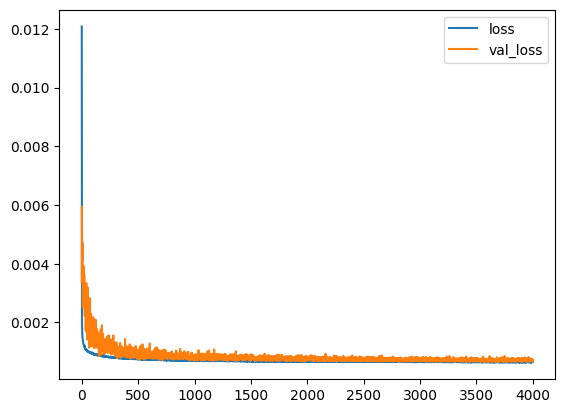

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()

In [31]:
# # This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:

def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return logits_adjusted

In [32]:
from sklearn.metrics import mean_squared_error
def compute_results(model, X_test, y_test):
    sngp_logits, sngp_covmat = model(X_test, return_covmat=True)
    sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
    std = np.sqrt(sngp_variance)
    std = np.mean(std)
    sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
    mse = mean_squared_error(sngp_probs, y_test)
    print(f'std: {std} -- mse:{mse}')
    return std, mse
compute_results(sngp_model, X_test, y_test)

std: 0.08526650816202164 -- mse:0.0006684923761477641


(0.08526651, 0.0006684923761477641)

In [33]:
compute_results(sngp_model, X_small_shift, y_small_shift)

std: 0.08535447716712952 -- mse:0.0006930540055948052


(0.08535448, 0.0006930540055948052)

In [34]:
compute_results(sngp_model, X_large_shift, y_large_shift)

std: 0.14716529846191406 -- mse:0.007241425992422729


(0.1471653, 0.007241425992422729)

In [ ]:
def ood_uncetainty(model, OOD):
    sngp_logits, sngp_covmat = model(OOD, return_covmat=True)
    sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
    std = np.sqrt(sngp_variance)
    std = np.mean(std)
    print(f'Uncertainty -- {std}')
    return std 

ood_uncetainty(sngp_model, OOD_1)
ood_uncetainty(sngp_model, OOD_2)
    

In [35]:
# MC Dropout
import seaborn as sns

In [36]:
num_ensemble = 10

In [37]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

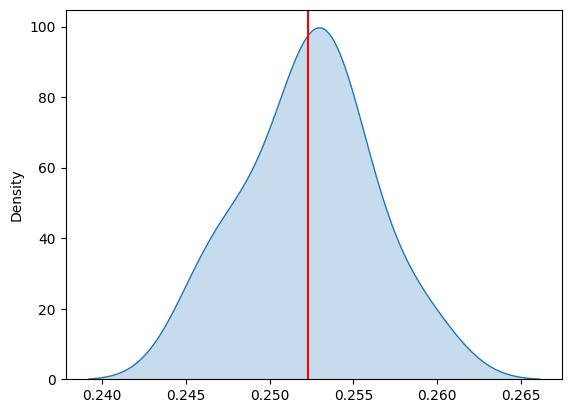

std: 0.007123221643269062 -- mse:0.00040511687072955277


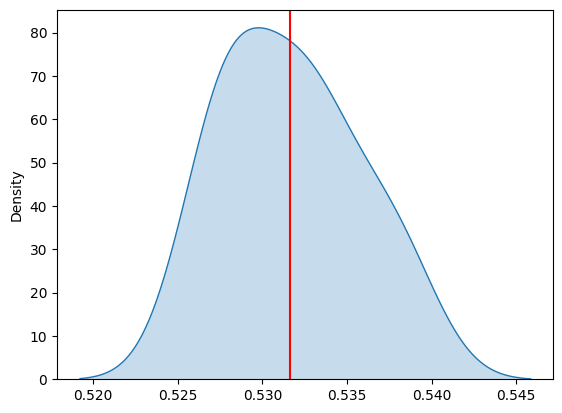

std: 0.007154562044888735 -- mse:0.0004837824306466247


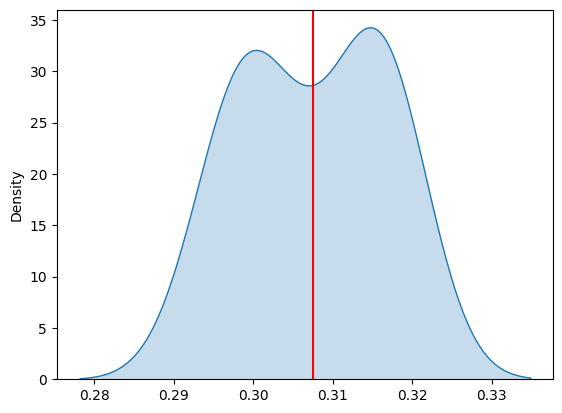

std: 0.010819830000400543 -- mse:0.004295848572507014


(0.01081983, 0.004295848572507014)

In [38]:
# Monte Carlo dropout inference.
def compute_mcdrop_out_results(model, X, y):
  pred_list = np.hstack([model(X) for _ in range(num_ensemble)])
  pred = pred_list.mean(axis = 1)

  # Plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.axvline(pred[0], color='red')
  plt.show()

  mse = mean_squared_error(pred, y)
  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)

  print(f'std: {std} -- mse:{mse}')
  return std, mse

compute_mcdrop_out_results(mc_dropout_sampling, X_test, y_test )
compute_mcdrop_out_results(mc_dropout_sampling, X_small_shift, y_small_shift )
compute_mcdrop_out_results(mc_dropout_sampling, X_large_shift, y_large_shift )

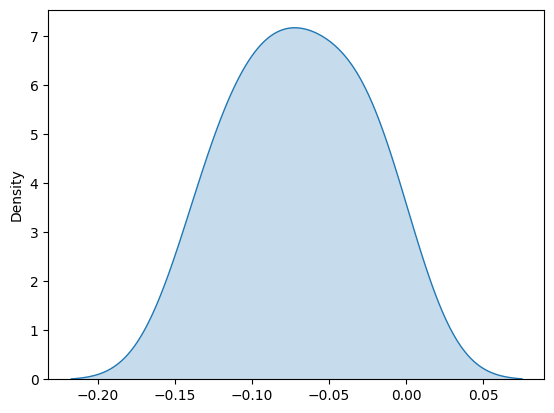

std -- 0.050446800887584686


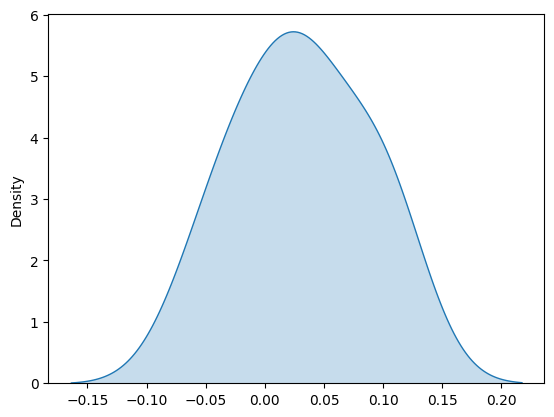

std -- 0.02523883990943432


0.02523884

In [39]:
def ood_uncertainty_mcdropout(model, ood_data):
  pred_list = np.hstack([model(ood_data) for _ in range(num_ensemble)])

  # plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.show()

  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)
  print(f'std -- {std}')
  return std

ood_uncertainty_mcdropout(mc_dropout_sampling, OOD_1)
ood_uncertainty_mcdropout(mc_dropout_sampling, OOD_2)

In [40]:
# Deep ensemble

In [41]:
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)
  resnet_ensemble.append(resnet_model)

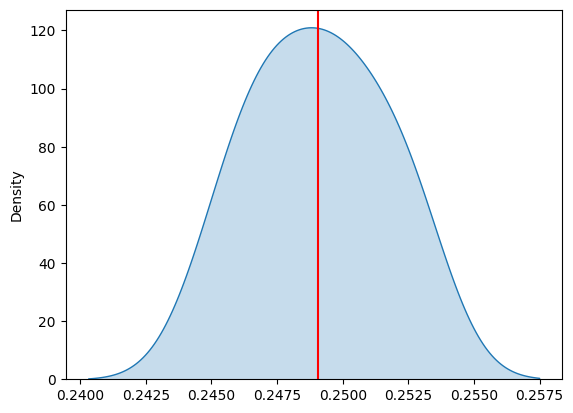

std: 0.00407126359641552 -- mse:0.000289635050697041


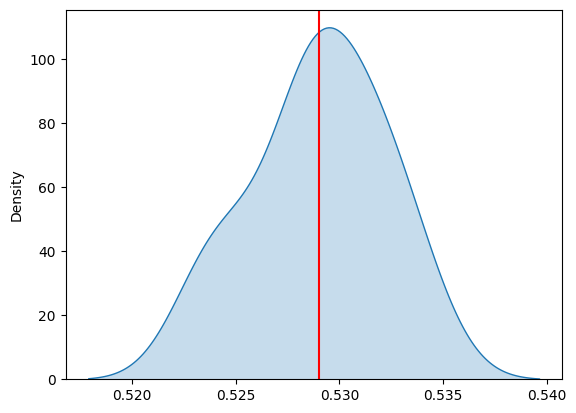

std: 0.004313529469072819 -- mse:0.0003438929353295881


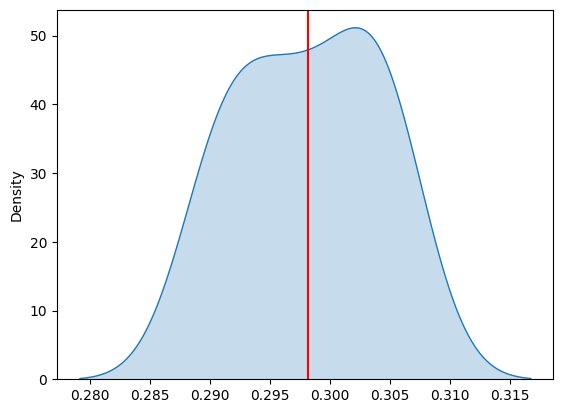

std: 0.013096549548208714 -- mse:0.004187817514332754


(0.01309655, 0.004187817514332754)

In [42]:
def compute_deep_ensemble_results(model_list, X, y):
  pred_list  = np.hstack([model(X) for model in model_list])
  pred = pred_list.mean(axis = 1)

  # plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.axvline(pred[0], color='red')
  plt.show()

  mse = mean_squared_error(pred, y)
  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)

  print(f'std: {std} -- mse:{mse}')
  return std, mse

compute_deep_ensemble_results(resnet_ensemble, X_test, y_test)
compute_deep_ensemble_results(resnet_ensemble, X_small_shift, y_small_shift)
compute_deep_ensemble_results(resnet_ensemble, X_large_shift, y_large_shift)

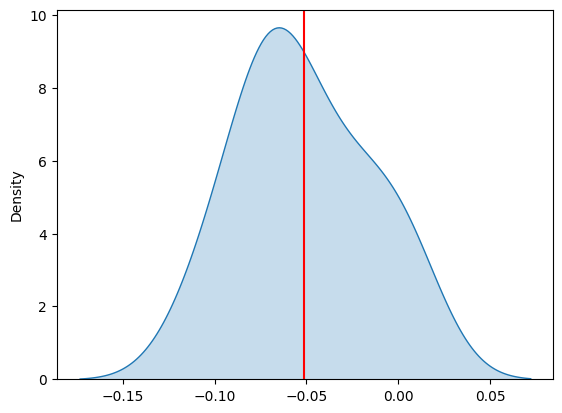

std -- 0.05722036212682724


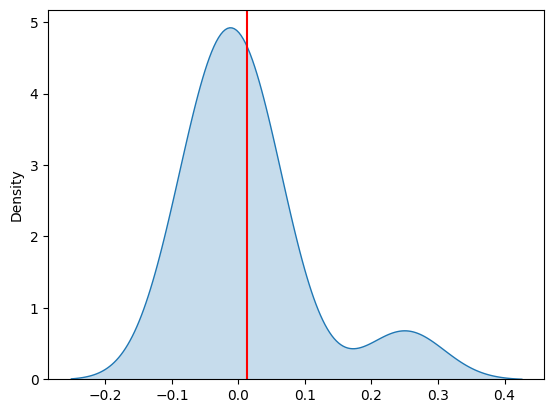

std -- 0.04425187036395073


0.04425187

In [43]:
def ood_uncertainty_deep_ensemble(model_list, ood_data):
  pred_list  = np.hstack([model(ood_data) for model in model_list])
  pred = pred_list.mean(axis = 1)
  # plot one test point
  sns.kdeplot(pred_list[0], fill=True)
  plt.axvline(pred[0], color='red')
  plt.show()
  std_list = [ np.std(i) for i in pred_list]
  std = np.mean(std_list)

  print(f'std -- {std}')
  return std

ood_uncertainty_deep_ensemble(resnet_ensemble, OOD_1)
ood_uncertainty_deep_ensemble(resnet_ensemble, OOD_2)